 ## Cell 1: Setup and Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Paths
PROCESSED_DIR = "../data/processed"
OUTPUT_DIR = "../outputs/feature_engineering"

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Phase 1 clean data
print(" LOADING PHASE 1 CLEAN DATA")
print("=" * 60)

df = pd.read_parquet(os.path.join(PROCESSED_DIR, "model1_phase1_clean.parquet"))

print(f"✓ Loaded: model1_phase1_clean.parquet")
print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"  Memory: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")

print(f"\n COLUMNS ({len(df.columns)}):")
for i, col in enumerate(df.columns):
    print(f"  {i+1:2}. {col} ({df[col].dtype})")




 LOADING PHASE 1 CLEAN DATA
✓ Loaded: model1_phase1_clean.parquet
  Shape: 137,556 rows × 34 columns
  Memory: 52.9 MB

 COLUMNS (34):
   1. count_point_id (int32)
   2. direction_of_travel (category)
   3. grid_id (int64)
   4. year (int16)
   5. count_date (datetime64[ns])
   6. hour (int8)
   7. month (int32)
   8. day_of_week (int32)
   9. region_id (int8)
  10. local_authority_id (Int16)
  11. road_name (object)
  12. road_category (object)
  13. road_type (object)
  14. road_type_simple (object)
  15. latitude (float32)
  16. longitude (float32)
  17. lgvs (int16)
  18. all_motor_vehicles (int32)
  19. non_hgv_vehicles (int32)
  20. all_hgvs (int16)
  21. temp_c (float32)
  22. rain_mm (float32)
  23. snow_cm (float32)
  24. wind_kph (float32)
  25. weather_code (int16)
  26. visibility_category (int8)
  27. is_fog (int8)
  28. is_reduced_visibility (int8)
  29. is_raining (int64)
  30. is_snowing (int64)
  31. is_cold (int64)
  32. is_high_wind (int64)
  33. is_weekend (int64)
 

## Cell 2: Document EDA Findings & Feature Decisions

In [2]:
print(" EDA FINDINGS SUMMARY")
print("=" * 60)

print("""
┌─────────────────────────────────────────────────────────────┐
│                    DATA CONSTRAINTS                         │
├─────────────────────────────────────────────────────────────┤
│ • Weekdays only: Monday-Friday (no weekend data)            │
│ • Business hours: 7am-6pm only (no night data)              │
│ • Missing months: Aug, Dec, Jan, Feb                        │
│ • Geographic scope: Southern England only                   │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│              MULTICOLLINEARITY FINDINGS                     │
├─────────────────────────────────────────────────────────────┤
│ HIGH VIF (>10) - Need attention:                            │
│   • visibility_category (VIF: very high)                    │
│   • is_raining (VIF: very high)                             │
│   • lgvs, non_hgv_vehicles (correlated pair)                │
│   • latitude (spatial)                                      │
│   • hour, temp_c (expected - keep)                          │
│                                                             │
│ HIGHLY CORRELATED PAIRS (|ρ| > 0.7):                        │
│   • rain_mm ↔ is_raining: ρ = 0.984 → REDUNDANT             │
│   • rain_mm ↔ visibility_category: ρ = -0.987 → REDUNDANT   │
│   • visibility_category ↔ is_raining: ρ = -0.997 → REDUNDANT│
│   • lgvs ↔ non_hgv_vehicles: ρ = 0.930 → Keep both          │
│   • lgvs ↔ all_hgvs: ρ = 0.861 → Expected (traffic)         │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│                  DATA LEAKAGE RISKS                         │
├─────────────────────────────────────────────────────────────┤
│ CRITICAL:                                                   │
│   • all_motor_vehicles CONTAINS all_hgvs (target)           │
│   • Already created: non_hgv_vehicles = AMV - HGVs          │
│                                                             │
│ TEMPORAL:                                                   │
│   • Must use temporal train/val/test split                  │
│   • No future information in training set                   │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│                TARGET VARIABLE                              │
├─────────────────────────────────────────────────────────────┤
│ • Name: all_hgvs (hourly HGV count)                         │
│ • Type: Count data (integer, non-negative)                  │
│ • Distribution: Right-skewed, overdispersed                 │
│ • Range: 0 to 1,290                                         │
│ • Mean: 103.9, Median: 38                                   │
│ • DO NOT TRANSFORM for tree-based models                    │
└─────────────────────────────────────────────────────────────┘
""")

# Verify target exists and is untouched
print("\n TARGET VARIABLE VERIFICATION:")
print(f"  Column exists: {'all_hgvs' in df.columns}")
print(f"  Type: {df['all_hgvs'].dtype}")
print(f"  Range: {df['all_hgvs'].min()} to {df['all_hgvs'].max()}")
print(f"  Mean: {df['all_hgvs'].mean():.1f}")
print(f"  Nulls: {df['all_hgvs'].isnull().sum()}")



 EDA FINDINGS SUMMARY

┌─────────────────────────────────────────────────────────────┐
│                    DATA CONSTRAINTS                         │
├─────────────────────────────────────────────────────────────┤
│ • Weekdays only: Monday-Friday (no weekend data)            │
│ • Business hours: 7am-6pm only (no night data)              │
│ • Missing months: Aug, Dec, Jan, Feb                        │
│ • Geographic scope: Southern England only                   │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│              MULTICOLLINEARITY FINDINGS                     │
├─────────────────────────────────────────────────────────────┤
│ HIGH VIF (>10) - Need attention:                            │
│   • visibility_category (VIF: very high)                    │
│   • is_raining (VIF: very high)                             │
│   • lgvs, non_hgv_vehicles (correlated pair)                │
│   • latitude (

## Cell 3: Remove Redundant Feature

In [3]:
print("  REMOVING REDUNDANT FEATURES")
print("=" * 60)

# Track changes
features_before = df.columns.tolist()
removal_log = []

# -------------------------------------------------------------------------
# 1. REMOVE: is_raining (perfectly correlated with rain_mm)
# -------------------------------------------------------------------------
if 'is_raining' in df.columns:
    corr_rain = df['rain_mm'].corr(df['is_raining'], method='spearman')
    print(f"\n is_raining")
    print(f"   Correlation with rain_mm: ρ = {corr_rain:.3f}")
    print(f"   REASON: Derived directly from rain_mm (rain_mm > 0)")
    print(f"   DECISION:  REMOVE - rain_mm is more informative (continuous)")
    df = df.drop(columns=['is_raining'])
    removal_log.append(('is_raining', 'Redundant with rain_mm (ρ=0.984)'))

# -------------------------------------------------------------------------
# 2. REMOVE: visibility_category (perfectly correlated with rain_mm)
# -------------------------------------------------------------------------
if 'visibility_category' in df.columns:
    corr_vis = df['rain_mm'].corr(df['visibility_category'], method='spearman')
    print(f"\n visibility_category")
    print(f"   Correlation with rain_mm: ρ = {corr_vis:.3f}")
    print(f"   REASON: Derived from weather_code which correlates with rain")
    print(f"   DECISION: REMOVE - provides no unique information")
    df = df.drop(columns=['visibility_category'])
    removal_log.append(('visibility_category', 'Redundant with rain_mm (ρ=-0.987)'))

# -------------------------------------------------------------------------
# 3. REMOVE: is_weekend (always 0 - no variance)
# -------------------------------------------------------------------------
if 'is_weekend' in df.columns:
    unique_vals = df['is_weekend'].unique()
    print(f"\n is_weekend")
    print(f"   Unique values: {unique_vals}")
    print(f"   REASON: No weekend data exists - always 0")
    print(f"   DECISION:  REMOVE - zero variance, useless")
    df = df.drop(columns=['is_weekend'])
    removal_log.append(('is_weekend', 'Zero variance (no weekend data)'))

# -------------------------------------------------------------------------
# 4. REMOVE: is_snowing (too sparse - <1% non-zero)
# -------------------------------------------------------------------------
if 'is_snowing' in df.columns:
    snow_pct = df['is_snowing'].mean() * 100
    print(f"\n is_snowing")
    print(f"   Non-zero percentage: {snow_pct:.2f}%")
    print(f"   REASON: Too sparse due to missing winter months")
    print(f"   DECISION: REMOVE - insufficient signal")
    df = df.drop(columns=['is_snowing'])
    removal_log.append(('is_snowing', f'Too sparse ({snow_pct:.2f}% non-zero)'))

# -------------------------------------------------------------------------
# 5. REMOVE: all_motor_vehicles (LEAKAGE - contains target)
# -------------------------------------------------------------------------
if 'all_motor_vehicles' in df.columns:
    print(f"\n all_motor_vehicles")
    print(f"   REASON: all_motor_vehicles = all_hgvs + other vehicles")
    print(f"   LEAKAGE: Contains target variable!")
    print(f"   DECISION: REMOVE - use non_hgv_vehicles instead")
    df = df.drop(columns=['all_motor_vehicles'])
    removal_log.append(('all_motor_vehicles', 'DATA LEAKAGE - contains target'))

# -------------------------------------------------------------------------
# 6. REMOVE: snow_cm (too sparse - same as is_snowing)
# -------------------------------------------------------------------------
if 'snow_cm' in df.columns:
    snow_nonzero = (df['snow_cm'] > 0).mean() * 100
    print(f"\n snow_cm")
    print(f"   Non-zero percentage: {snow_nonzero:.2f}%")
    print(f"   REASON: Too sparse, missing winter months")
    print(f"   DECISION: REMOVE - insufficient signal")
    df = df.drop(columns=['snow_cm'])
    removal_log.append(('snow_cm', f'Too sparse ({snow_nonzero:.2f}% non-zero)'))

# -------------------------------------------------------------------------
# 7. REMOVE: is_fog (sparse and correlated with is_reduced_visibility)
# -------------------------------------------------------------------------
if 'is_fog' in df.columns:
    fog_pct = df['is_fog'].mean() * 100
    print(f"\n is_fog")
    print(f"   Non-zero percentage: {fog_pct:.2f}%")
    if 'is_reduced_visibility' in df.columns:
        # Check if fog is subset of reduced visibility
        fog_in_reduced = df[df['is_fog'] == 1]['is_reduced_visibility'].mean()
        print(f"   Fog observations also in reduced_visibility: {fog_in_reduced*100:.1f}%")
    print(f"   REASON: Sparse, is_reduced_visibility is more comprehensive")
    print(f"   DECISION: REMOVE - keep is_reduced_visibility instead")
    df = df.drop(columns=['is_fog'])
    removal_log.append(('is_fog', 'Sparse, redundant with is_reduced_visibility'))

# -------------------------------------------------------------------------
# 8. REMOVE: season (incomplete due to missing months)
# -------------------------------------------------------------------------
if 'season' in df.columns:
    season_dist = df['season'].value_counts()
    print(f"\n season")
    print(f"   Distribution: {dict(season_dist)}")
    print(f"   REASON: Incomplete - Winter/Summer missing months")
    print(f"   DECISION: REMOVE - temp_c captures seasonality better")
    df = df.drop(columns=['season'])
    removal_log.append(('season', 'Incomplete seasonal coverage'))

# -------------------------------------------------------------------------
# 9. REMOVE: weather_code (raw code, already extracted features)
# -------------------------------------------------------------------------
if 'weather_code' in df.columns:
    print(f"\n weather_code")
    print(f"   Unique codes: {df['weather_code'].nunique()}")
    print(f"   REASON: Already extracted into binary features")
    print(f"   DECISION: REMOVE - derived features are cleaner")
    df = df.drop(columns=['weather_code'])
    removal_log.append(('weather_code', 'Raw code - derived features extracted'))

# -------------------------------------------------------------------------
# SUMMARY
# -------------------------------------------------------------------------
print("\n" + "=" * 60)
print(" REMOVAL SUMMARY")
print("=" * 60)

print(f"\n  Features before: {len(features_before)}")
print(f"  Features removed: {len(removal_log)}")
print(f"  Features after: {len(df.columns)}")

print(f"\n  REMOVED FEATURES:")
for feat, reason in removal_log:
    print(f"    REMOVE {feat}: {reason}")

print(f"\n  REMAINING FEATURES ({len(df.columns)}):")
for col in df.columns:
    print(f"    ✓ {col}")



  REMOVING REDUNDANT FEATURES

 is_raining
   Correlation with rain_mm: ρ = 0.984
   REASON: Derived directly from rain_mm (rain_mm > 0)
   DECISION:  REMOVE - rain_mm is more informative (continuous)

 visibility_category
   Correlation with rain_mm: ρ = -0.987
   REASON: Derived from weather_code which correlates with rain
   DECISION: REMOVE - provides no unique information

 is_weekend
   Unique values: [0]
   REASON: No weekend data exists - always 0
   DECISION:  REMOVE - zero variance, useless

 is_snowing
   Non-zero percentage: 0.33%
   REASON: Too sparse due to missing winter months
   DECISION: REMOVE - insufficient signal

 all_motor_vehicles
   REASON: all_motor_vehicles = all_hgvs + other vehicles
   LEAKAGE: Contains target variable!
   DECISION: REMOVE - use non_hgv_vehicles instead

 snow_cm
   Non-zero percentage: 0.33%
   REASON: Too sparse, missing winter months
   DECISION: REMOVE - insufficient signal

 is_fog
   Non-zero percentage: 0.00%
   Fog observations also

## Cell 4: Data Leakage Prevention & Verification

In [4]:
print(" DATA LEAKAGE PREVENTION & VERIFICATION")
print("=" * 60)

# Define target
TARGET = 'all_hgvs'

# -------------------------------------------------------------------------
# 1. CHECK: No features derived from target
# -------------------------------------------------------------------------
print("\n CHECKING FOR TARGET-DERIVED FEATURES")

leakage_suspects = []

# Check correlation with target
for col in df.columns:
    if col == TARGET:
        continue
    if df[col].dtype in ['int8', 'int16', 'int32', 'int64', 'float32', 'float64']:
        corr = df[col].corr(df[TARGET], method='pearson')
        if abs(corr) > 0.9:
            leakage_suspects.append((col, corr))
            print(f"   {col}: r = {corr:.3f} (HIGH - investigate)")

if not leakage_suspects:
    print("  ✓ No features with suspiciously high correlation (>0.9)")
else:
    print(f"\n  INVESTIGATE THESE {len(leakage_suspects)} FEATURES:")
    for feat, corr in leakage_suspects:
        print(f"    • {feat}: r = {corr:.3f}")

# -------------------------------------------------------------------------
# 2. VERIFY: all_motor_vehicles removed
# -------------------------------------------------------------------------
print("\n VERIFYING LEAKY FEATURES REMOVED")

leaky_features = ['all_motor_vehicles']
for feat in leaky_features:
    if feat in df.columns:
        print(f"  REMOVE {feat} STILL EXISTS - REMOVE IT!")
    else:
        print(f"  ✓ {feat} removed")

# -------------------------------------------------------------------------
# 3. CHECK: lgvs and non_hgv_vehicles
# -------------------------------------------------------------------------
print("\n CHECKING TRAFFIC FEATURES")

if 'lgvs' in df.columns:
    lgv_corr = df['lgvs'].corr(df[TARGET], method='pearson')
    print(f"  lgvs ↔ {TARGET}: r = {lgv_corr:.3f}")
    print(f"    → High correlation is EXPECTED (traffic patterns)")
    print(f"    → NOT leakage - lgvs is independent count")

if 'non_hgv_vehicles' in df.columns:
    nonhgv_corr = df['non_hgv_vehicles'].corr(df[TARGET], method='pearson')
    print(f"  non_hgv_vehicles ↔ {TARGET}: r = {nonhgv_corr:.3f}")
    print(f"    → Moderate correlation expected (traffic patterns)")
    print(f"    → NOT leakage - HGVs already subtracted")

# -------------------------------------------------------------------------
# 4. VERIFY: Target unchanged
# -------------------------------------------------------------------------
print("\n TARGET VARIABLE INTEGRITY CHECK")

print(f"  Column: {TARGET}")
print(f"  Type: {df[TARGET].dtype}")
print(f"  Min: {df[TARGET].min()}")
print(f"  Max: {df[TARGET].max()}")
print(f"  Mean: {df[TARGET].mean():.2f}")
print(f"  Nulls: {df[TARGET].isnull().sum()}")
print(f"  ✓ Target preserved without transformation")

# -------------------------------------------------------------------------
# 5. TEMPORAL LEAKAGE NOTE
# -------------------------------------------------------------------------
print("\n TEMPORAL LEAKAGE PREVENTION")
print("""
  IMPORTANT: Train/Val/Test split MUST be temporal:
  
  ┌─────────────────────────────────────────────────────┐
  │ TRAIN: Mar 2022 - Jun 2023 (~60%)                   │
  │ VAL:   Jul 2023 - Dec 2023 (~20%)                   │
  │ TEST:  Jan 2024 - Nov 2024 (~20%)                   │
  └─────────────────────────────────────────────────────┘
  
  This prevents future information leaking into training.
  Split will be done in Cell 8.
""")

print("\n" + "=" * 60)
print("✅ LEAKAGE PREVENTION CHECKS COMPLETE")
print("=" * 60)


 DATA LEAKAGE PREVENTION & VERIFICATION

 CHECKING FOR TARGET-DERIVED FEATURES
  ✓ No features with suspiciously high correlation (>0.9)

 VERIFYING LEAKY FEATURES REMOVED
  ✓ all_motor_vehicles removed

 CHECKING TRAFFIC FEATURES
  lgvs ↔ all_hgvs: r = 0.788
    → High correlation is EXPECTED (traffic patterns)
    → NOT leakage - lgvs is independent count
  non_hgv_vehicles ↔ all_hgvs: r = 0.685
    → Moderate correlation expected (traffic patterns)
    → NOT leakage - HGVs already subtracted

 TARGET VARIABLE INTEGRITY CHECK
  Column: all_hgvs
  Type: int16
  Min: 0
  Max: 1290
  Mean: 103.89
  Nulls: 0
  ✓ Target preserved without transformation

 TEMPORAL LEAKAGE PREVENTION

  IMPORTANT: Train/Val/Test split MUST be temporal:

  ┌─────────────────────────────────────────────────────┐
  │ TRAIN: Mar 2022 - Jun 2023 (~60%)                   │
  │ VAL:   Jul 2023 - Dec 2023 (~20%)                   │
  │ TEST:  Jan 2024 - Nov 2024 (~20%)                   │
  └───────────────────────

## Cell 5: Categorize Final Features

In [5]:
print(" CATEGORIZING FINAL FEATURES")
print("=" * 60)

# Define feature categories
IDENTIFIERS = ['count_point_id', 'direction_of_travel', 'grid_id']
TEMPORAL_RAW = ['year', 'count_date']
TARGET = 'all_hgvs'

# Categorize remaining features
TEMPORAL_FEATURES = ['hour', 'day_of_week', 'month']
SPATIAL_NUMERIC = ['latitude', 'longitude']
SPATIAL_CATEGORICAL = ['region_id', 'local_authority_id', 'road_name', 'road_category', 'road_type', 'road_type_simple']
TRAFFIC_FEATURES = ['lgvs', 'non_hgv_vehicles']
WEATHER_CONTINUOUS = ['temp_c', 'rain_mm', 'wind_kph']
WEATHER_BINARY = ['is_cold', 'is_high_wind', 'is_reduced_visibility']

# Filter to columns that actually exist
def filter_existing(feature_list):
    return [f for f in feature_list if f in df.columns]

IDENTIFIERS = filter_existing(IDENTIFIERS)
TEMPORAL_RAW = filter_existing(TEMPORAL_RAW)
TEMPORAL_FEATURES = filter_existing(TEMPORAL_FEATURES)
SPATIAL_NUMERIC = filter_existing(SPATIAL_NUMERIC)
SPATIAL_CATEGORICAL = filter_existing(SPATIAL_CATEGORICAL)
TRAFFIC_FEATURES = filter_existing(TRAFFIC_FEATURES)
WEATHER_CONTINUOUS = filter_existing(WEATHER_CONTINUOUS)
WEATHER_BINARY = filter_existing(WEATHER_BINARY)

print("\n FEATURE CATEGORIES:")

print(f"\n  IDENTIFIERS (not for modeling): {len(IDENTIFIERS)}")
for f in IDENTIFIERS:
    print(f"    • {f}")

print(f"\n  TEMPORAL RAW (not for modeling): {len(TEMPORAL_RAW)}")
for f in TEMPORAL_RAW:
    print(f"    • {f}")

print(f"\n  TARGET: {TARGET}")

print(f"\n  TEMPORAL FEATURES: {len(TEMPORAL_FEATURES)}")
for f in TEMPORAL_FEATURES:
    print(f"    • {f} (range: {df[f].min()}-{df[f].max()})")

print(f"\n  SPATIAL NUMERIC: {len(SPATIAL_NUMERIC)}")
for f in SPATIAL_NUMERIC:
    print(f"    • {f}")

print(f"\n  SPATIAL CATEGORICAL: {len(SPATIAL_CATEGORICAL)}")
for f in SPATIAL_CATEGORICAL:
    nunique = df[f].nunique()
    print(f"    • {f} ({nunique} unique)")

print(f"\n  TRAFFIC FEATURES: {len(TRAFFIC_FEATURES)}")
for f in TRAFFIC_FEATURES:
    print(f"    • {f}")

print(f"\n  WEATHER CONTINUOUS: {len(WEATHER_CONTINUOUS)}")
for f in WEATHER_CONTINUOUS:
    print(f"    • {f}")

print(f"\n  WEATHER BINARY: {len(WEATHER_BINARY)}")
for f in WEATHER_BINARY:
    pct = df[f].mean() * 100
    print(f"    • {f} ({pct:.1f}% = 1)")

# Define modeling features
NUMERIC_FEATURES = TEMPORAL_FEATURES + SPATIAL_NUMERIC + TRAFFIC_FEATURES + WEATHER_CONTINUOUS
BINARY_FEATURES = WEATHER_BINARY
CATEGORICAL_FEATURES = SPATIAL_CATEGORICAL

print(f"\n" + "=" * 60)
print(f" FEATURE SUMMARY FOR MODELING")
print(f"=" * 60)
print(f"  Numeric features: {len(NUMERIC_FEATURES)}")
print(f"  Binary features: {len(BINARY_FEATURES)}")
print(f"  Categorical features: {len(CATEGORICAL_FEATURES)}")
print(f"  Total modeling features: {len(NUMERIC_FEATURES) + len(BINARY_FEATURES) + len(CATEGORICAL_FEATURES)}")




 CATEGORIZING FINAL FEATURES

 FEATURE CATEGORIES:

  IDENTIFIERS (not for modeling): 3
    • count_point_id
    • direction_of_travel
    • grid_id

  TEMPORAL RAW (not for modeling): 2
    • year
    • count_date

  TARGET: all_hgvs

  TEMPORAL FEATURES: 3
    • hour (range: 7-18)
    • day_of_week (range: 0-4)
    • month (range: 3-11)

  SPATIAL NUMERIC: 2
    • latitude
    • longitude

  SPATIAL CATEGORICAL: 6
    • region_id (9 unique)
    • local_authority_id (144 unique)
    • road_name (871 unique)
    • road_category (4 unique)
    • road_type (1 unique)
    • road_type_simple (2 unique)

  TRAFFIC FEATURES: 2
    • lgvs
    • non_hgv_vehicles

  WEATHER CONTINUOUS: 3
    • temp_c
    • rain_mm
    • wind_kph

  WEATHER BINARY: 3
    • is_cold (1.2% = 1)
    • is_high_wind (0.0% = 1)
    • is_reduced_visibility (1.7% = 1)

 FEATURE SUMMARY FOR MODELING
  Numeric features: 10
  Binary features: 3
  Categorical features: 6
  Total modeling features: 19


## Cell 6: Feature Encoding Strategy



In [6]:
print(" FEATURE ENCODING STRATEGY")
print("=" * 60)

# Create a copy for feature engineering
df_fe = df.copy()

# -------------------------------------------------------------------------
# 1. CYCLICAL ENCODING FOR TEMPORAL FEATURES
# -------------------------------------------------------------------------
print("\n CYCLICAL ENCODING (Temporal Features)")
print("-" * 60)

# Hour: 7-18 (12 hours in our data)
if 'hour' in df_fe.columns:
    # Normalize to full 24-hour cycle for proper encoding
    df_fe['hour_sin'] = np.sin(2 * np.pi * df_fe['hour'] / 24)
    df_fe['hour_cos'] = np.cos(2 * np.pi * df_fe['hour'] / 24)
    print(f"  ✓ hour → hour_sin, hour_cos (24-hour cycle)")

# Day of week: 0-4 (only weekdays in our data)
if 'day_of_week' in df_fe.columns:
    # Encode as 5-day cycle (Mon-Fri)
    df_fe['dow_sin'] = np.sin(2 * np.pi * df_fe['day_of_week'] / 5)
    df_fe['dow_cos'] = np.cos(2 * np.pi * df_fe['day_of_week'] / 5)
    print(f"  ✓ day_of_week → dow_sin, dow_cos (5-day cycle)")

# Month: has gaps, so use raw or temperature as proxy
if 'month' in df_fe.columns:
    df_fe['month_sin'] = np.sin(2 * np.pi * df_fe['month'] / 12)
    df_fe['month_cos'] = np.cos(2 * np.pi * df_fe['month'] / 12)
    print(f"  ✓ month → month_sin, month_cos (12-month cycle)")
    print(f"    Note: Month has gaps - temp_c may be better proxy")

# -------------------------------------------------------------------------
# 2. CATEGORICAL ENCODING DECISION
# -------------------------------------------------------------------------
print("\n CATEGORICAL ENCODING STRATEGY")
print("-" * 60)

print("""
  HIGH CARDINALITY FEATURES (too many categories for one-hot):
    • road_name: {road_name_n} unique → Use for grouping only
    • local_authority_id: {la_n} unique → Use for grouping only
  
  LOW/MEDIUM CARDINALITY (can one-hot encode):
    • road_type_simple: 2 unique → One-hot encode
    • road_category: few unique → One-hot encode
    • region_id: few unique → One-hot encode
    
  DECISION: For unsupervised learning, we'll use numeric features only.
            For supervised learning, we'll encode key categoricals.
""".format(
    road_name_n=df_fe['road_name'].nunique() if 'road_name' in df_fe.columns else 'N/A',
    la_n=df_fe['local_authority_id'].nunique() if 'local_authority_id' in df_fe.columns else 'N/A'
))

# One-hot encode road_type_simple
if 'road_type_simple' in df_fe.columns:
    df_fe['is_motorway'] = (df_fe['road_type_simple'] == 'Motorway').astype(int)
    print(f"  ✓ road_type_simple → is_motorway (binary)")

# -------------------------------------------------------------------------
# 3. BINARY FEATURES - ALREADY ENCODED
# -------------------------------------------------------------------------
print("\n3️⃣ BINARY FEATURES (Already Encoded)")
print("-" * 60)

for bf in WEATHER_BINARY:
    if bf in df_fe.columns:
        print(f"  ✓ {bf}: {df_fe[bf].unique()} (ready)")

# -------------------------------------------------------------------------
# 4. SUMMARY OF ENCODED FEATURES
# -------------------------------------------------------------------------
print("\n" + "=" * 60)
print(" ENCODED FEATURES SUMMARY")
print("=" * 60)

new_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 
                'month_sin', 'month_cos', 'is_motorway']
new_features = [f for f in new_features if f in df_fe.columns]

print(f"\n  NEW ENGINEERED FEATURES ({len(new_features)}):")
for f in new_features:
    print(f"    + {f}")

print(f"\n  Current shape: {df_fe.shape}")




 FEATURE ENCODING STRATEGY

 CYCLICAL ENCODING (Temporal Features)
------------------------------------------------------------
  ✓ hour → hour_sin, hour_cos (24-hour cycle)
  ✓ day_of_week → dow_sin, dow_cos (5-day cycle)
  ✓ month → month_sin, month_cos (12-month cycle)
    Note: Month has gaps - temp_c may be better proxy

 CATEGORICAL ENCODING STRATEGY
------------------------------------------------------------

  HIGH CARDINALITY FEATURES (too many categories for one-hot):
    • road_name: 871 unique → Use for grouping only
    • local_authority_id: 144 unique → Use for grouping only

  LOW/MEDIUM CARDINALITY (can one-hot encode):
    • road_type_simple: 2 unique → One-hot encode
    • road_category: few unique → One-hot encode
    • region_id: few unique → One-hot encode

  DECISION: For unsupervised learning, we'll use numeric features only.
            For supervised learning, we'll encode key categoricals.

  ✓ road_type_simple → is_motorway (binary)

3️⃣ BINARY FEATURES (Alr

In [7]:
df_fe.columns.tolist()

['count_point_id',
 'direction_of_travel',
 'grid_id',
 'year',
 'count_date',
 'hour',
 'month',
 'day_of_week',
 'region_id',
 'local_authority_id',
 'road_name',
 'road_category',
 'road_type',
 'road_type_simple',
 'latitude',
 'longitude',
 'lgvs',
 'non_hgv_vehicles',
 'all_hgvs',
 'temp_c',
 'rain_mm',
 'wind_kph',
 'is_reduced_visibility',
 'is_cold',
 'is_high_wind',
 'hour_sin',
 'hour_cos',
 'dow_sin',
 'dow_cos',
 'month_sin',
 'month_cos',
 'is_motorway']

## Cell 7: Define Feature Sets for Different Models

In [8]:
print("DEFINING FEATURE SETS FOR MODELING")
print("=" * 60)

# -------------------------------------------------------------------------
# 1. FEATURES FOR UNSUPERVISED LEARNING
# -------------------------------------------------------------------------
print("\n UNSUPERVISED LEARNING FEATURES")
print("-" * 60)

# Use only numeric features that describe observation characteristics
# Exclude: identifiers, target, high-cardinality categoricals

UNSUPERVISED_FEATURES = [
    # Temporal (cyclical encoded)
    'hour_sin', 'hour_cos',
    'dow_sin', 'dow_cos',
    # Spatial (numeric)
    'latitude', 'longitude',
    # Traffic context
    'lgvs', 'non_hgv_vehicles',
    # Weather
    'temp_c', 'rain_mm', 'wind_kph',
    # Binary
    'is_cold', 'is_high_wind', 'is_reduced_visibility',
    'is_motorway'
]

# Filter to existing
UNSUPERVISED_FEATURES = [f for f in UNSUPERVISED_FEATURES if f in df_fe.columns]

print(f"  Features for clustering ({len(UNSUPERVISED_FEATURES)}):")
for f in UNSUPERVISED_FEATURES:
    print(f"    • {f}")

# -------------------------------------------------------------------------
# 2. FEATURES FOR SUPERVISED REGRESSION
# -------------------------------------------------------------------------
print("\n SUPERVISED REGRESSION FEATURES")
print("-" * 60)

# Include more features for prediction
REGRESSION_FEATURES = [
    # Temporal (cyclical + raw)
    'hour', 'day_of_week',
    'hour_sin', 'hour_cos',
    'dow_sin', 'dow_cos',
    # Spatial
    'latitude', 'longitude',
    'is_motorway',
    # Traffic
    'lgvs', 'non_hgv_vehicles',
    # Weather
    'temp_c', 'rain_mm', 'wind_kph',
    # Binary
    'is_cold', 'is_high_wind', 'is_reduced_visibility'
]

REGRESSION_FEATURES = [f for f in REGRESSION_FEATURES if f in df_fe.columns]

print(f"  Features for regression ({len(REGRESSION_FEATURES)}):")
for f in REGRESSION_FEATURES:
    print(f"    • {f}")

# -------------------------------------------------------------------------
# 3. FEATURES FOR SUPERVISED CLASSIFICATION
# -------------------------------------------------------------------------
print("\n SUPERVISED CLASSIFICATION FEATURES")
print("-" * 60)

# Same features as regression
CLASSIFICATION_FEATURES = REGRESSION_FEATURES.copy()

print(f"  Features for classification ({len(CLASSIFICATION_FEATURES)}):")
print(f"    (Same as regression features)")

# -------------------------------------------------------------------------
# 4. CREATE CLASSIFICATION TARGET
# -------------------------------------------------------------------------
print("\n CREATING CLASSIFICATION TARGET")
print("-" * 60)

# Define HGV volume categories based on distribution
# Using percentiles to create balanced classes

p33 = df_fe['all_hgvs'].quantile(0.33)
p67 = df_fe['all_hgvs'].quantile(0.67)

print(f"  Target distribution percentiles:")
print(f"    33rd percentile: {p33:.0f}")
print(f"    67th percentile: {p67:.0f}")

# Create 3-class target
def classify_hgv(x):
    if x <= p33:
        return 0  # Low
    elif x <= p67:
        return 1  # Medium
    else:
        return 2  # High

df_fe['hgv_class'] = df_fe['all_hgvs'].apply(classify_hgv)

class_dist = df_fe['hgv_class'].value_counts().sort_index()
print(f"\n  Classification target (hgv_class):")
print(f"    0 (Low, ≤{p33:.0f}): {class_dist[0]:,} ({class_dist[0]/len(df_fe)*100:.1f}%)")
print(f"    1 (Medium, {p33:.0f}-{p67:.0f}): {class_dist[1]:,} ({class_dist[1]/len(df_fe)*100:.1f}%)")
print(f"    2 (High, >{p67:.0f}): {class_dist[2]:,} ({class_dist[2]/len(df_fe)*100:.1f}%)")

# Also create binary target (High vs Not-High)
median_hgv = df_fe['all_hgvs'].median()
df_fe['hgv_high'] = (df_fe['all_hgvs'] > median_hgv).astype(int)

print(f"\n  Binary target (hgv_high, threshold={median_hgv:.0f}):")
print(f"    0 (Not High): {(df_fe['hgv_high']==0).sum():,} ({(df_fe['hgv_high']==0).mean()*100:.1f}%)")
print(f"    1 (High): {(df_fe['hgv_high']==1).sum():,} ({(df_fe['hgv_high']==1).mean()*100:.1f}%)")

# -------------------------------------------------------------------------
# 5. SUMMARY
# -------------------------------------------------------------------------
print("\n" + "=" * 60)
print(" FEATURE SETS SUMMARY")
print("=" * 60)

print(f"""
  UNSUPERVISED:  {len(UNSUPERVISED_FEATURES)} features
  REGRESSION:    {len(REGRESSION_FEATURES)} features
  CLASSIFICATION:{len(CLASSIFICATION_FEATURES)} features
  
  TARGETS:
    • all_hgvs (regression - continuous count)
    • hgv_class (3-class: Low/Medium/High)
    • hgv_high (binary: High vs Not-High)
""")



DEFINING FEATURE SETS FOR MODELING

 UNSUPERVISED LEARNING FEATURES
------------------------------------------------------------
  Features for clustering (15):
    • hour_sin
    • hour_cos
    • dow_sin
    • dow_cos
    • latitude
    • longitude
    • lgvs
    • non_hgv_vehicles
    • temp_c
    • rain_mm
    • wind_kph
    • is_cold
    • is_high_wind
    • is_reduced_visibility
    • is_motorway

 SUPERVISED REGRESSION FEATURES
------------------------------------------------------------
  Features for regression (17):
    • hour
    • day_of_week
    • hour_sin
    • hour_cos
    • dow_sin
    • dow_cos
    • latitude
    • longitude
    • is_motorway
    • lgvs
    • non_hgv_vehicles
    • temp_c
    • rain_mm
    • wind_kph
    • is_cold
    • is_high_wind
    • is_reduced_visibility

 SUPERVISED CLASSIFICATION FEATURES
------------------------------------------------------------
  Features for classification (17):
    (Same as regression features)

 CREATING CLASSIFICATION TA

## Cell 8: Temporal Train/Validation/Test Split

TEMPORAL TRAIN/TEST SPLIT

 DATE RANGE ANALYSIS
  Data range: 2022-03-18 to 2024-11-07
  Total span: 965 days (~2.6 years)

  Monthly observation counts:
    2022-03: 3,432
    2022-04: 9,324
    2022-05: 7,980
    2022-06: 6,924
    2022-07: 8,160
    2022-09: 8,376
    2022-10: 3,552
    2022-11: 120
    2023-03: 3,660
    2023-04: 8,208
    2023-05: 7,212
    2023-06: 8,568
    2023-07: 5,112
    2023-09: 5,508
    2023-10: 4,368
    2023-11: 264
    2024-03: 2,136
    2024-04: 10,464
    2024-05: 7,548
    2024-06: 10,308
    2024-07: 7,764
    2024-09: 6,192
    2024-10: 2,112
    2024-11: 264

 DEFINING TEMPORAL SPLIT (80/20)
------------------------------------------------------------

  SPLIT BOUNDARY: 2024-05-23

  SPLIT SIZES:
    TRAIN: 110,472 (80.3%)
    TEST:  27,084 (19.7%)

 VERIFYING NO TEMPORAL LEAKAGE
  Train max date: 2024-05-23
  Test min date:  2024-05-24

  NO TEMPORAL LEAKAGE - dates are strictly ordered

 TARGET DISTRIBUTION ACROSS SPLITS

  TRAIN:
    all_hgvs

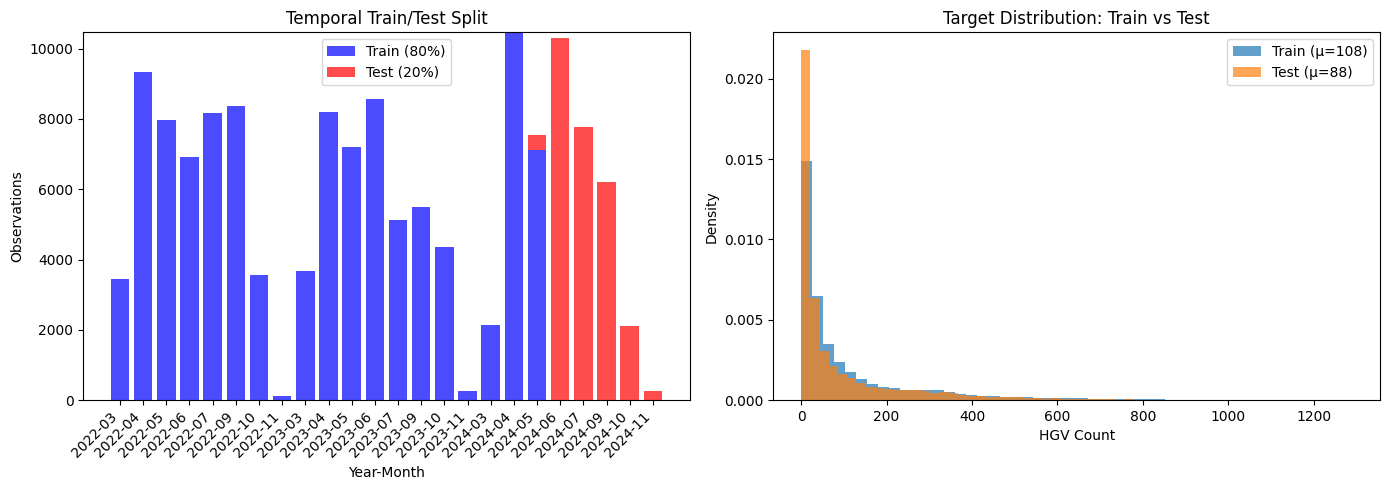

  ✓ Saved: ../outputs/feature_engineering/temporal_split.png

 CROSS-VALIDATION STRATEGY
------------------------------------------------------------

  For hyperparameter tuning, use TimeSeriesSplit on training data:

  from sklearn.model_selection import TimeSeriesSplit

  tscv = TimeSeriesSplit(n_splits=5)
  for train_idx, val_idx in tscv.split(X_train):
      # Train on train_idx, validate on val_idx

  This prevents temporal leakage during CV.


 TEMPORAL SPLIT COMPLETE
  Train: 110,472 samples (80.3%)
  Test:  27,084 samples (19.7%)


In [9]:


print("TEMPORAL TRAIN/TEST SPLIT")
print("=" * 60)

# -------------------------------------------------------------------------
# 1. EXAMINE DATE RANGE
# -------------------------------------------------------------------------
print("\n DATE RANGE ANALYSIS")

date_min = df_fe['count_date'].min()
date_max = df_fe['count_date'].max()
total_days = (date_max - date_min).days

print(f"  Data range: {date_min.date()} to {date_max.date()}")
print(f"  Total span: {total_days} days (~{total_days/365:.1f} years)")

# Monthly distribution
monthly_counts = df_fe.groupby(df_fe['count_date'].dt.to_period('M')).size()
print(f"\n  Monthly observation counts:")
for period, count in monthly_counts.items():
    print(f"    {period}: {count:,}")

# -------------------------------------------------------------------------
# 2. DEFINE TEMPORAL SPLIT (80/20)
# -------------------------------------------------------------------------
print("\n DEFINING TEMPORAL SPLIT (80/20)")
print("-" * 60)

# Calculate 80th percentile date
df_fe_sorted = df_fe.sort_values('count_date')
n_total = len(df_fe_sorted)
n_train = int(n_total * 0.80)

# Find the split date
split_idx = df_fe_sorted.index[n_train]
TRAIN_END = df_fe_sorted.loc[split_idx, 'count_date']

# Create masks
train_mask = df_fe['count_date'] <= TRAIN_END
test_mask = df_fe['count_date'] > TRAIN_END

df_train = df_fe[train_mask].copy()
df_test = df_fe[test_mask].copy()

print(f"\n  SPLIT BOUNDARY: {TRAIN_END.date()}")
print(f"\n  SPLIT SIZES:")
print(f"    TRAIN: {len(df_train):,} ({len(df_train)/len(df_fe)*100:.1f}%)")
print(f"    TEST:  {len(df_test):,} ({len(df_test)/len(df_fe)*100:.1f}%)")

# -------------------------------------------------------------------------
# 3. VERIFY NO TEMPORAL LEAKAGE
# -------------------------------------------------------------------------
print("\n VERIFYING NO TEMPORAL LEAKAGE")

train_max_date = df_train['count_date'].max()
test_min_date = df_test['count_date'].min()

print(f"  Train max date: {train_max_date.date()}")
print(f"  Test min date:  {test_min_date.date()}")

if train_max_date < test_min_date:
    print("\n  NO TEMPORAL LEAKAGE - dates are strictly ordered")
else:
    print("\n  WARNING: Check date ordering!")

# -------------------------------------------------------------------------
# 4. VERIFY TARGET DISTRIBUTION ACROSS SPLITS
# -------------------------------------------------------------------------
print("\n TARGET DISTRIBUTION ACROSS SPLITS")

for split_name, split_df in [('TRAIN', df_train), ('TEST', df_test)]:
    print(f"\n  {split_name}:")
    print(f"    all_hgvs mean: {split_df['all_hgvs'].mean():.1f}")
    print(f"    all_hgvs median: {split_df['all_hgvs'].median():.0f}")
    print(f"    all_hgvs std: {split_df['all_hgvs'].std():.1f}")
    print(f"    Date range: {split_df['count_date'].min().date()} to {split_df['count_date'].max().date()}")

# -------------------------------------------------------------------------
# 5. VISUALIZE SPLIT
# -------------------------------------------------------------------------
print("\n VISUALIZING TEMPORAL SPLIT")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Monthly observation counts with split coloring
monthly_train = df_train.groupby(df_train['count_date'].dt.to_period('M')).size()
monthly_test = df_test.groupby(df_test['count_date'].dt.to_period('M')).size()

all_periods = sorted(set(monthly_train.index) | set(monthly_test.index))
x_positions = range(len(all_periods))
x_labels = [str(p) for p in all_periods]

train_heights = [monthly_train.get(p, 0) for p in all_periods]
test_heights = [monthly_test.get(p, 0) for p in all_periods]

axes[0].bar(x_positions, train_heights, color='blue', alpha=0.7, label='Train (80%)')
axes[0].bar(x_positions, test_heights, bottom=train_heights, color='red', alpha=0.7, label='Test (20%)')

axes[0].set_xticks(x_positions)
axes[0].set_xticklabels(x_labels, rotation=45, ha='right')
axes[0].set_xlabel('Year-Month')
axes[0].set_ylabel('Observations')
axes[0].set_title('Temporal Train/Test Split')
axes[0].legend()

# Plot 2: Target distribution comparison
axes[1].hist(df_train['all_hgvs'], bins=50, alpha=0.7, label=f'Train (μ={df_train["all_hgvs"].mean():.0f})', density=True)
axes[1].hist(df_test['all_hgvs'], bins=50, alpha=0.7, label=f'Test (μ={df_test["all_hgvs"].mean():.0f})', density=True)
axes[1].set_xlabel('HGV Count')
axes[1].set_ylabel('Density')
axes[1].set_title('Target Distribution: Train vs Test')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'temporal_split.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"  ✓ Saved: {OUTPUT_DIR}/temporal_split.png")

# -------------------------------------------------------------------------
# 6. NOTE ON CROSS-VALIDATION
# -------------------------------------------------------------------------
print("\n CROSS-VALIDATION STRATEGY")
print("-" * 60)
print("""
  For hyperparameter tuning, use TimeSeriesSplit on training data:
  
  from sklearn.model_selection import TimeSeriesSplit
  
  tscv = TimeSeriesSplit(n_splits=5)
  for train_idx, val_idx in tscv.split(X_train):
      # Train on train_idx, validate on val_idx
      
  This prevents temporal leakage during CV.
""")

# Store split info
SPLIT_INFO = {
    'train_end': str(TRAIN_END.date()),
    'train_size': len(df_train),
    'test_size': len(df_test),
    'train_pct': len(df_train) / len(df_fe) * 100,
    'test_pct': len(df_test) / len(df_fe) * 100
}

print("\n" + "=" * 60)
print(" TEMPORAL SPLIT COMPLETE")
print("=" * 60)
print(f"  Train: {len(df_train):,} samples ({SPLIT_INFO['train_pct']:.1f}%)")
print(f"  Test:  {len(df_test):,} samples ({SPLIT_INFO['test_pct']:.1f}%)")

## Cell 9: Feature Scaling (Fit on Train Only)

In [10]:
print(" FEATURE SCALING")
print("=" * 60)

# -------------------------------------------------------------------------
# 1. IDENTIFY FEATURES TO SCALE
# -------------------------------------------------------------------------
print("\n FEATURES TO SCALE")

FEATURES_TO_SCALE = [
    'latitude', 'longitude',
    'lgvs', 'non_hgv_vehicles',
    'temp_c', 'rain_mm', 'wind_kph',
    'hour_sin', 'hour_cos',
    'dow_sin', 'dow_cos',
    'month_sin', 'month_cos'
]

FEATURES_TO_SCALE = [f for f in FEATURES_TO_SCALE if f in df_train.columns]
print(f"  Features to scale: {len(FEATURES_TO_SCALE)}")

# -------------------------------------------------------------------------
# 2. FIT SCALER ON TRAINING DATA ONLY
# -------------------------------------------------------------------------
print("\n FITTING SCALER ON TRAINING DATA")

from sklearn.preprocessing import RobustScaler

scaler_robust = RobustScaler()
scaler_robust.fit(df_train[FEATURES_TO_SCALE])
print("  ✓ RobustScaler fitted on train data")

# -------------------------------------------------------------------------
# 3. TRANSFORM BOTH SPLITS
# -------------------------------------------------------------------------
print("\n TRANSFORMING TRAIN AND TEST")

for split_name, split_df in [('train', df_train), ('test', df_test)]:
    scaled = scaler_robust.transform(split_df[FEATURES_TO_SCALE])
    for i, col in enumerate(FEATURES_TO_SCALE):
        split_df[f'{col}_scaled'] = scaled[:, i]
    print(f"  ✓ {split_name.upper()} scaled")

print("\n" + "=" * 60)
print(" SCALING COMPLETE")
print("=" * 60)




 FEATURE SCALING

 FEATURES TO SCALE
  Features to scale: 13

 FITTING SCALER ON TRAINING DATA
  ✓ RobustScaler fitted on train data

 TRANSFORMING TRAIN AND TEST
  ✓ TRAIN scaled
  ✓ TEST scaled

 SCALING COMPLETE


 ## Cell 10: Prepare Data for Unsupervised Learning

In [11]:
print(" PREPARING DATA FOR UNSUPERVISED LEARNING")
print("=" * 60)

# -------------------------------------------------------------------------
# 1. DEFINE FEATURES FOR UNSUPERVISED LEARNING
# -------------------------------------------------------------------------
print("\n FEATURES FOR UNSUPERVISED LEARNING")

UNSUP_FEATURES_RAW = [
    'hour_sin', 'hour_cos',
    'dow_sin', 'dow_cos',
    'latitude', 'longitude',
    'lgvs', 'non_hgv_vehicles',
    'temp_c', 'rain_mm', 'wind_kph',
]

UNSUP_FEATURES_BINARY = ['is_cold', 'is_high_wind', 'is_reduced_visibility', 'is_motorway']

UNSUP_FEATURES_RAW = [f for f in UNSUP_FEATURES_RAW if f in df_train.columns]
UNSUP_FEATURES_BINARY = [f for f in UNSUP_FEATURES_BINARY if f in df_train.columns]

print(f"  Continuous features: {len(UNSUP_FEATURES_RAW)}")
print(f"  Binary features: {len(UNSUP_FEATURES_BINARY)}")

# -------------------------------------------------------------------------
# 2. FIT SCALER ON TRAIN DATA ONLY
# -------------------------------------------------------------------------
print("\n FITTING SCALER ON TRAIN DATA")

scaler_unsup = RobustScaler()
scaler_unsup.fit(df_train[UNSUP_FEATURES_RAW])
print("  ✓ RobustScaler fitted on training data")

# -------------------------------------------------------------------------
# 3. TRANSFORM BOTH SPLITS
# -------------------------------------------------------------------------
print("\n TRANSFORMING TRAIN AND TEST")

X_train_scaled = scaler_unsup.transform(df_train[UNSUP_FEATURES_RAW])
X_test_scaled = scaler_unsup.transform(df_test[UNSUP_FEATURES_RAW])

X_train_unsup = np.hstack([X_train_scaled, df_train[UNSUP_FEATURES_BINARY].values])
X_test_unsup = np.hstack([X_test_scaled, df_test[UNSUP_FEATURES_BINARY].values])

UNSUP_FEATURE_NAMES = UNSUP_FEATURES_RAW + UNSUP_FEATURES_BINARY

print(f"  X_train_unsup: {X_train_unsup.shape}")
print(f"  X_test_unsup: {X_test_unsup.shape}")

# Handle NaN/Inf
X_train_unsup = np.nan_to_num(X_train_unsup, nan=0, posinf=0, neginf=0)
X_test_unsup = np.nan_to_num(X_test_unsup, nan=0, posinf=0, neginf=0)

print("\n  ✓ Data ready for UMAP + clustering")



 PREPARING DATA FOR UNSUPERVISED LEARNING

 FEATURES FOR UNSUPERVISED LEARNING
  Continuous features: 11
  Binary features: 4

 FITTING SCALER ON TRAIN DATA
  ✓ RobustScaler fitted on training data

 TRANSFORMING TRAIN AND TEST
  X_train_unsup: (110472, 15)
  X_test_unsup: (27084, 15)

  ✓ Data ready for UMAP + clustering


 ## Cell 11: UMAP Dimensionality Reduction (Fit on Train)

UMAP DIMENSIONALITY REDUCTION

 PREPARING TRAINING DATA FOR UMAP
  Training data (110,472) > 30,000
  Sampling for UMAP fitting...
  Data for UMAP fitting: (30000, 15)

 FITTING UMAP
------------------------------------------------------------
  Fitting UMAP on training data...
UMAP(n_jobs=1, random_state=42, verbose=True)
Wed Jan 14 16:08:17 2026 Construct fuzzy simplicial set
Wed Jan 14 16:08:17 2026 Finding Nearest Neighbors
Wed Jan 14 16:08:17 2026 Building RP forest with 14 trees
Wed Jan 14 16:08:23 2026 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Wed Jan 14 16:08:37 2026 Finished Nearest Neighbor Search
Wed Jan 14 16:08:39 2026 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Jan 14 16:08:51 2026 Finished embedding
  ✓ UMAP fitted

 TRANSFORMING TRAIN AND TEST
  Transforming train...
Wed Jan 14 16:08:51 2026 Building hub-based search tree
Wed Jan 14 16:09:00 2026 Forward diversification reduced edges from 450000 to 162378
Wed Jan 14 16:09:03 2026 Reverse diversification reduced edges from 162378 to 162378
Wed Jan 14 16:09:05 2026 Degree pruning reduced edges from 161350 to 161350
Wed Jan 14 16:09:05 2026 Resorting data and graph based on tree order
Wed Jan 14 16:09:05 2026 Building and compiling search function


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
  Transforming test...


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs

  UMAP embeddings:
    Train: (110472, 2)
    Test: (27084, 2)

 ADDING UMAP FEATURES TO DATAFRAMES
  ✓ Added: umap_1, umap_2

 VISUALIZING UMAP EMBEDDING


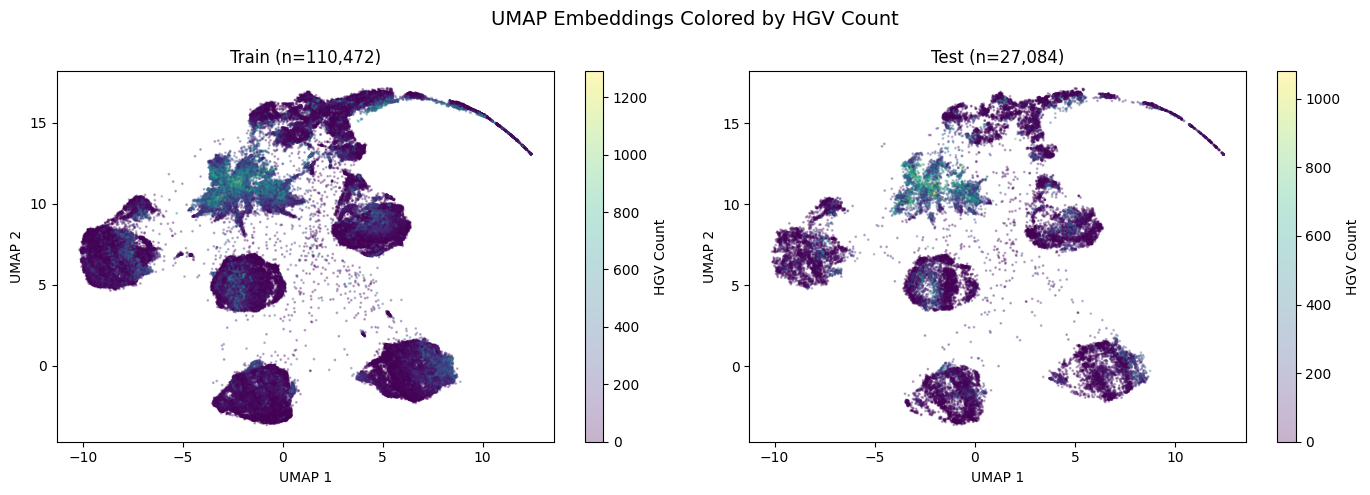

  ✓ Saved: ../outputs/feature_engineering/umap_embedding.png


In [12]:
print("UMAP DIMENSIONALITY REDUCTION")
print("=" * 60)

try:
    import umap
except ImportError:
    print("  Installing umap-learn...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'umap-learn', '-q'])
    import umap

from umap import UMAP

# -------------------------------------------------------------------------
# 1. SAMPLE TRAINING DATA FOR UMAP FITTING (if large)
# -------------------------------------------------------------------------
print("\n PREPARING TRAINING DATA FOR UMAP")

UMAP_FIT_MAX = 30000

if len(X_train_unsup) > UMAP_FIT_MAX:
    print(f"  Training data ({len(X_train_unsup):,}) > {UMAP_FIT_MAX:,}")
    print(f"  Sampling for UMAP fitting...")
    np.random.seed(42)
    fit_idx = np.random.choice(len(X_train_unsup), size=UMAP_FIT_MAX, replace=False)
    X_train_fit = X_train_unsup[fit_idx]
else:
    X_train_fit = X_train_unsup
    
print(f"  Data for UMAP fitting: {X_train_fit.shape}")

# -------------------------------------------------------------------------
# 2. FIT UMAP ON TRAINING DATA
# -------------------------------------------------------------------------
print("\n FITTING UMAP")
print("-" * 60)

umap_model = UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    random_state=42,
    n_jobs=-1,
    verbose=True
)

print("  Fitting UMAP on training data...")
umap_model.fit(X_train_fit)
print("  ✓ UMAP fitted")

# -------------------------------------------------------------------------
# 3. TRANSFORM TRAIN AND TEST
# -------------------------------------------------------------------------
print("\n TRANSFORMING TRAIN AND TEST")

print("  Transforming train...")
umap_train = umap_model.transform(X_train_unsup)
print("  Transforming test...")
umap_test = umap_model.transform(X_test_unsup)

print(f"\n  UMAP embeddings:")
print(f"    Train: {umap_train.shape}")
print(f"    Test: {umap_test.shape}")

# -------------------------------------------------------------------------
# 4. ADD UMAP EMBEDDINGS TO DATAFRAMES
# -------------------------------------------------------------------------
print("\n ADDING UMAP FEATURES TO DATAFRAMES")

df_train['umap_1'] = umap_train[:, 0]
df_train['umap_2'] = umap_train[:, 1]

df_test['umap_1'] = umap_test[:, 0]
df_test['umap_2'] = umap_test[:, 1]

print("  ✓ Added: umap_1, umap_2")

# -------------------------------------------------------------------------
# 5. VISUALIZE UMAP EMBEDDING
# -------------------------------------------------------------------------
print("\n VISUALIZING UMAP EMBEDDING")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scatter1 = axes[0].scatter(umap_train[:, 0], umap_train[:, 1], 
                           c=df_train['all_hgvs'], cmap='viridis', 
                           alpha=0.3, s=1)
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
axes[0].set_title(f'Train (n={len(umap_train):,})')
plt.colorbar(scatter1, ax=axes[0], label='HGV Count')

scatter2 = axes[1].scatter(umap_test[:, 0], umap_test[:, 1], 
                           c=df_test['all_hgvs'], cmap='viridis', 
                           alpha=0.3, s=1)
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].set_title(f'Test (n={len(umap_test):,})')
plt.colorbar(scatter2, ax=axes[1], label='HGV Count')

plt.suptitle('UMAP Embeddings Colored by HGV Count', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'umap_embedding.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"  ✓ Saved: {OUTPUT_DIR}/umap_embedding.png")



 ## Cell 12: KMeans Clustering (Fit on Train)



 KMEANS CLUSTERING

 FINDING OPTIMAL NUMBER OF CLUSTERS
  Testing k values...
    k=3: inertia=1880361, silhouette=0.496
    k=4: inertia=1451264, silhouette=0.515
    k=5: inertia=1076231, silhouette=0.506
    k=6: inertia=695564, silhouette=0.570
    k=7: inertia=443505, silhouette=0.617
    k=8: inertia=312210, silhouette=0.643
    k=9: inertia=267019, silhouette=0.632
    k=10: inertia=242186, silhouette=0.594
    k=11: inertia=218594, silhouette=0.582
    k=12: inertia=206327, silhouette=0.525
    k=13: inertia=187243, silhouette=0.522
    k=14: inertia=176480, silhouette=0.481
    k=15: inertia=163837, silhouette=0.473
    k=16: inertia=152859, silhouette=0.439
    k=17: inertia=143832, silhouette=0.448

  Best k by silhouette: 8

 VISUALIZING CLUSTER SELECTION


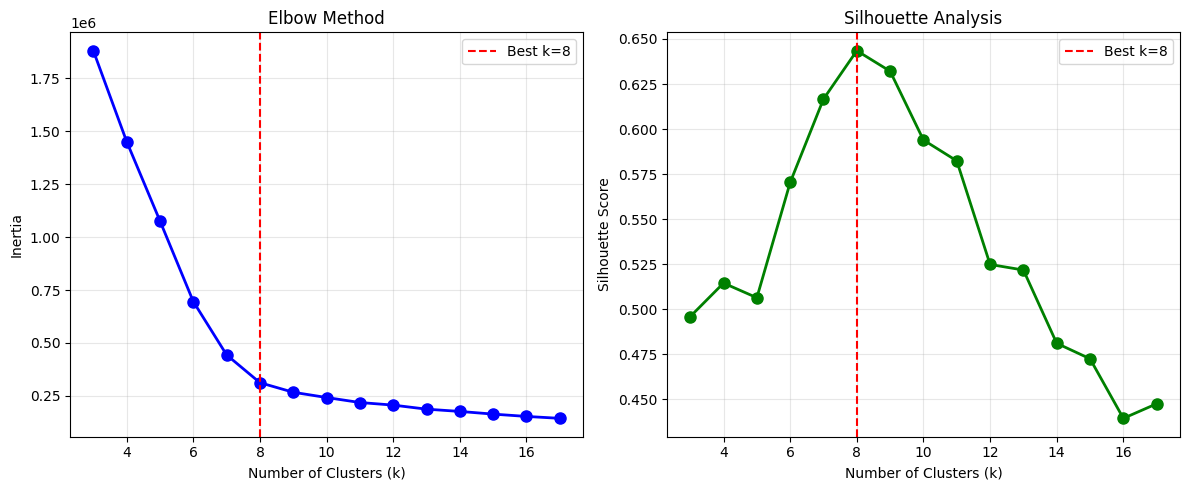

  ✓ Saved: ../outputs/feature_engineering/kmeans_selection.png

 FITTING FINAL KMEANS (k=8)
  ✓ KMeans fitted with 8 clusters

 PREDICTING CLUSTERS
  ✓ Added: cluster_kmeans

  Cluster distribution:
    Train: {np.int32(0): np.int64(17236), np.int32(1): np.int64(15247), np.int32(2): np.int64(4651), np.int32(3): np.int64(13640), np.int32(4): np.int64(16649), np.int32(5): np.int64(15275), np.int32(6): np.int64(13493), np.int32(7): np.int64(14281)}
    Test: {np.int32(0): np.int64(4596), np.int32(1): np.int64(3380), np.int32(2): np.int64(1119), np.int32(3): np.int64(3920), np.int32(4): np.int64(3662), np.int32(5): np.int64(3635), np.int32(6): np.int64(3493), np.int32(7): np.int64(3279)}

 VISUALIZING KMEANS CLUSTERS


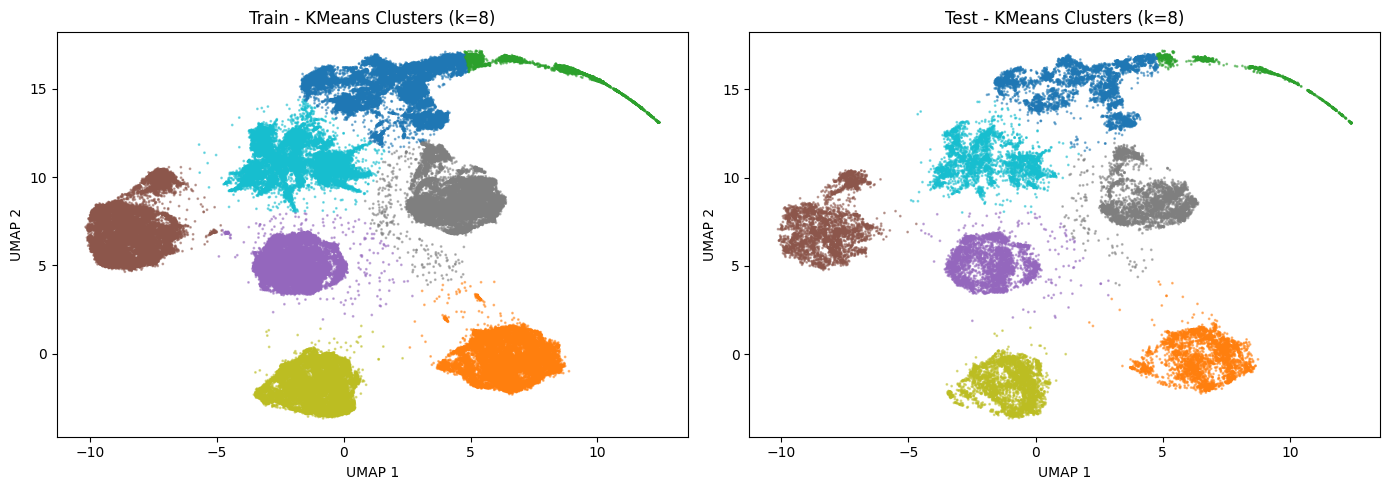

  ✓ Saved: ../outputs/feature_engineering/kmeans_clusters.png

 CLUSTER PROFILES (Train Data)
------------------------------------------------------------
               all_hgvs                       hour   lgvs temp_c
                   mean median    std  count  mean   mean   mean
cluster_kmeans                                                  
0                  78.7   33.0  110.7  17236  12.5  186.1   13.0
1                  72.2   34.0   98.1  15247  12.3  182.0   14.8
2                 103.9   38.0  148.6   4651  13.1  247.6   13.3
3                  71.6   33.0  101.6  13640  12.5  178.1   14.4
4                  65.1   32.0   86.7  16649  12.5  167.7   14.1
5                  63.7   29.0   85.4  15275  12.6  169.9   14.8
6                  57.3   28.0   75.9  13493  12.5  171.1   15.9
7                 360.5  320.0  209.6  14281  12.5  681.8   14.4


In [13]:
print(" KMEANS CLUSTERING")
print("=" * 60)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -------------------------------------------------------------------------
# 1. DETERMINE OPTIMAL K
# -------------------------------------------------------------------------
print("\n FINDING OPTIMAL NUMBER OF CLUSTERS")

X_cluster_train = umap_train

k_range = range(3, 18)
inertias = []
silhouettes = []

print("  Testing k values...")
for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_temp.fit_predict(X_cluster_train)
    inertias.append(kmeans_temp.inertia_)
    sil = silhouette_score(X_cluster_train, labels, sample_size=min(10000, len(X_cluster_train)))
    silhouettes.append(sil)
    print(f"    k={k}: inertia={kmeans_temp.inertia_:.0f}, silhouette={sil:.3f}")

best_k = k_range[np.argmax(silhouettes)]
print(f"\n  Best k by silhouette: {best_k}")

# -------------------------------------------------------------------------
# 2. VISUALIZE CLUSTER SELECTION
# -------------------------------------------------------------------------
print("\n VISUALIZING CLUSTER SELECTION")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(list(k_range), inertias, 'b-o', linewidth=2, markersize=8)
axes[0].axvline(x=best_k, color='red', linestyle='--', label=f'Best k={best_k}')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(list(k_range), silhouettes, 'g-o', linewidth=2, markersize=8)
axes[1].axvline(x=best_k, color='red', linestyle='--', label=f'Best k={best_k}')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'kmeans_selection.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"  ✓ Saved: {OUTPUT_DIR}/kmeans_selection.png")

# -------------------------------------------------------------------------
# 3. FIT FINAL KMEANS MODEL
# -------------------------------------------------------------------------
print(f"\n FITTING FINAL KMEANS (k={best_k})")

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_final.fit(X_cluster_train)
print(f"  ✓ KMeans fitted with {best_k} clusters")

# -------------------------------------------------------------------------
# 4. PREDICT CLUSTERS FOR TRAIN AND TEST
# -------------------------------------------------------------------------
print("\n PREDICTING CLUSTERS")

cluster_train = kmeans_final.predict(umap_train)
cluster_test = kmeans_final.predict(umap_test)

df_train['cluster_kmeans'] = cluster_train
df_test['cluster_kmeans'] = cluster_test

print(f"  ✓ Added: cluster_kmeans")

print("\n  Cluster distribution:")
for split_name, labels in [('Train', cluster_train), ('Test', cluster_test)]:
    unique, counts = np.unique(labels, return_counts=True)
    dist = dict(zip(unique, counts))
    print(f"    {split_name}: {dist}")

# -------------------------------------------------------------------------
# 5. VISUALIZE CLUSTERS
# -------------------------------------------------------------------------
print("\n VISUALIZING KMEANS CLUSTERS")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, umap_data, labels) in zip(axes, 
    [('Train', umap_train, cluster_train), ('Test', umap_test, cluster_test)]):
    scatter = ax.scatter(umap_data[:, 0], umap_data[:, 1], 
                        c=labels, cmap='tab10', alpha=0.5, s=1)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title(f'{name} - KMeans Clusters (k={best_k})')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'kmeans_clusters.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"  ✓ Saved: {OUTPUT_DIR}/kmeans_clusters.png")

# -------------------------------------------------------------------------
# 6. CLUSTER PROFILES
# -------------------------------------------------------------------------
print("\n CLUSTER PROFILES (Train Data)")
print("-" * 60)

cluster_profiles = df_train.groupby('cluster_kmeans').agg({
    'all_hgvs': ['mean', 'median', 'std', 'count'],
    'hour': 'mean',
    'lgvs': 'mean',
    'temp_c': 'mean'
}).round(1)

print(cluster_profiles.to_string())



 ## Cell 13: HDBSCAN Clustering (Fit on Train)

 HDBSCAN CLUSTERING

 FITTING HDBSCAN
  ✓ HDBSCAN fitted
  Clusters found: 5
  Noise points: 164 (0.1%)

 PREDICTING FOR TEST
  ✓ Added: cluster_hdbscan

  Cluster distribution:
    Train: 5 clusters, 0.1% noise
    Test: 5 clusters, 0.3% noise

 VISUALIZING HDBSCAN CLUSTERS


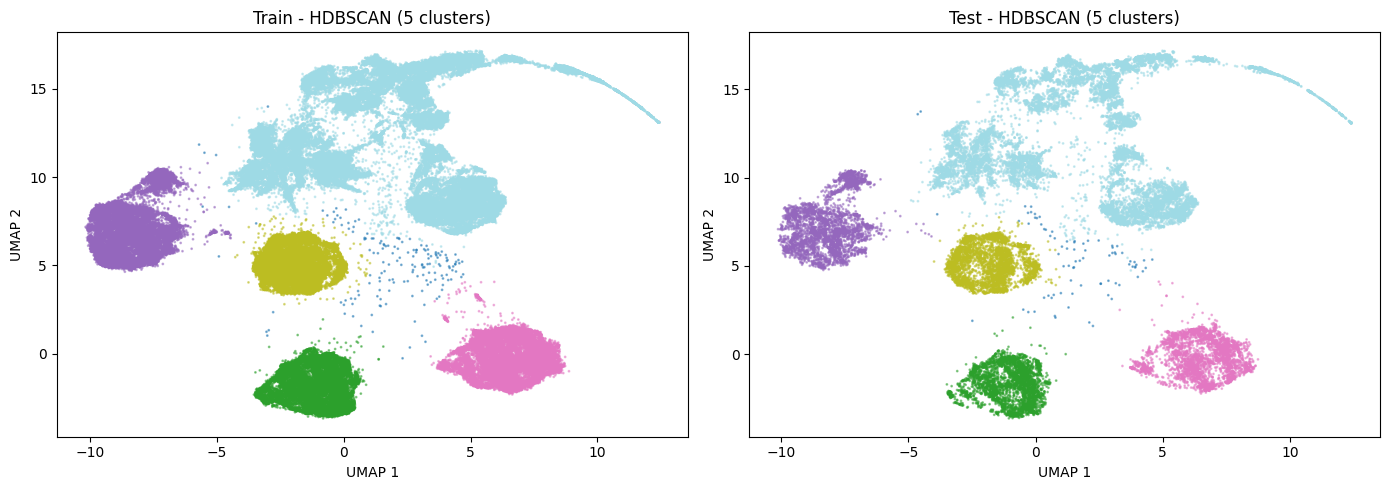

  ✓ Saved: ../outputs/feature_engineering/hdbscan_clusters.png

 ADDING NOISE INDICATOR
  ✓ Added: is_noise_hdb


In [14]:
print(" HDBSCAN CLUSTERING")
print("=" * 60)

try:
    import hdbscan
except ImportError:
    print("  Installing hdbscan...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'hdbscan', '-q'])
    import hdbscan

# -------------------------------------------------------------------------
# 1. FIT HDBSCAN ON TRAINING DATA
# -------------------------------------------------------------------------
print("\n FITTING HDBSCAN")

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=500,
    min_samples=50,
    cluster_selection_epsilon=0.5,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

cluster_train_hdb = hdbscan_model.fit_predict(umap_train)

n_clusters_hdb = len(set(cluster_train_hdb)) - (1 if -1 in cluster_train_hdb else 0)
n_noise = (cluster_train_hdb == -1).sum()

print(f"  ✓ HDBSCAN fitted")
print(f"  Clusters found: {n_clusters_hdb}")
print(f"  Noise points: {n_noise} ({n_noise/len(cluster_train_hdb)*100:.1f}%)")

# -------------------------------------------------------------------------
# 2. PREDICT FOR TEST
# -------------------------------------------------------------------------
print("\n PREDICTING FOR TEST")

cluster_test_hdb, _ = hdbscan.approximate_predict(hdbscan_model, umap_test)

df_train['cluster_hdbscan'] = cluster_train_hdb
df_test['cluster_hdbscan'] = cluster_test_hdb

print(f"  ✓ Added: cluster_hdbscan")

print("\n  Cluster distribution:")
for split_name, labels in [('Train', cluster_train_hdb), ('Test', cluster_test_hdb)]:
    unique, counts = np.unique(labels, return_counts=True)
    noise_pct = (labels == -1).sum() / len(labels) * 100
    print(f"    {split_name}: {len(unique)-1 if -1 in unique else len(unique)} clusters, {noise_pct:.1f}% noise")

# -------------------------------------------------------------------------
# 3. VISUALIZE HDBSCAN CLUSTERS
# -------------------------------------------------------------------------
print("\n VISUALIZING HDBSCAN CLUSTERS")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, umap_data, labels) in zip(axes, 
    [('Train', umap_train, cluster_train_hdb), ('Test', umap_test, cluster_test_hdb)]):
    colors = labels.copy().astype(float)
    colors[labels == -1] = -1
    scatter = ax.scatter(umap_data[:, 0], umap_data[:, 1], 
                        c=colors, cmap='tab20', alpha=0.5, s=1)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title(f'{name} - HDBSCAN ({n_clusters_hdb} clusters)')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'hdbscan_clusters.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"  ✓ Saved: {OUTPUT_DIR}/hdbscan_clusters.png")

# -------------------------------------------------------------------------
# 4. ADD NOISE INDICATOR
# -------------------------------------------------------------------------
print("\n ADDING NOISE INDICATOR")

df_train['is_noise_hdb'] = (df_train['cluster_hdbscan'] == -1).astype(int)
df_test['is_noise_hdb'] = (df_test['cluster_hdbscan'] == -1).astype(int)

print(f"  ✓ Added: is_noise_hdb")




 ## Cell 14: Advanced Feature Engineering from KMeans Clusters

In [15]:
print("  ADVANCED FEATURE ENGINEERING FROM KMEANS")
print("=" * 60)

# -------------------------------------------------------------------------
# 1. ANALYZE CLUSTER CHARACTERISTICS
# -------------------------------------------------------------------------
print("\n ANALYZING CLUSTER CHARACTERISTICS")
print("-" * 60)

# Get detailed cluster profiles
cluster_stats = df_train.groupby('cluster_kmeans').agg({
    'all_hgvs': ['mean', 'median', 'std'],
    'lgvs': 'mean',
    'non_hgv_vehicles': 'mean',
    'hour': 'mean',
    'temp_c': 'mean',
    'rain_mm': 'mean',
    'latitude': 'mean',
    'longitude': 'mean',
    'is_motorway': 'mean'
}).round(2)

print("\n  Cluster Statistics:")
print(cluster_stats.to_string())

# Identify cluster types based on HGV volume
cluster_hgv_means = df_train.groupby('cluster_kmeans')['all_hgvs'].mean()
high_traffic_clusters = cluster_hgv_means[cluster_hgv_means > cluster_hgv_means.quantile(0.75)].index.tolist()
low_traffic_clusters = cluster_hgv_means[cluster_hgv_means < cluster_hgv_means.quantile(0.25)].index.tolist()
medium_traffic_clusters = [c for c in cluster_hgv_means.index if c not in high_traffic_clusters and c not in low_traffic_clusters]

print(f"\n  Cluster Classification by HGV Volume:")
print(f"    HIGH traffic clusters: {high_traffic_clusters} (mean HGV > {cluster_hgv_means.quantile(0.75):.0f})")
print(f"    MEDIUM traffic clusters: {medium_traffic_clusters}")
print(f"    LOW traffic clusters: {low_traffic_clusters} (mean HGV < {cluster_hgv_means.quantile(0.25):.0f})")

# -------------------------------------------------------------------------
# 2. CREATE BINARY CLUSTER FEATURES
# -------------------------------------------------------------------------
print("\n CREATING BINARY CLUSTER FEATURES")
print("-" * 60)

# High traffic indicator
df_train['is_high_traffic_cluster'] = df_train['cluster_kmeans'].isin(high_traffic_clusters).astype(int)
df_test['is_high_traffic_cluster'] = df_test['cluster_kmeans'].isin(high_traffic_clusters).astype(int)
print(f"  ✓ is_high_traffic_cluster: {df_train['is_high_traffic_cluster'].mean()*100:.1f}% in train")

# Low traffic indicator
df_train['is_low_traffic_cluster'] = df_train['cluster_kmeans'].isin(low_traffic_clusters).astype(int)
df_test['is_low_traffic_cluster'] = df_test['cluster_kmeans'].isin(low_traffic_clusters).astype(int)
print(f"  ✓ is_low_traffic_cluster: {df_train['is_low_traffic_cluster'].mean()*100:.1f}% in train")

# -------------------------------------------------------------------------
# 3. CREATE CLUSTER-BASED AGGREGATE FEATURES
# -------------------------------------------------------------------------
print("\n CREATING CLUSTER-BASED AGGREGATE FEATURES")
print("-" * 60)

# Calculate cluster statistics from TRAINING data only (prevent leakage)
cluster_agg_train = df_train.groupby('cluster_kmeans').agg({
    'all_hgvs': ['mean', 'std'],
    'lgvs': 'mean',
    'non_hgv_vehicles': 'mean'
}).reset_index()

cluster_agg_train.columns = ['cluster_kmeans', 'cluster_hgv_mean', 'cluster_hgv_std', 
                              'cluster_lgv_mean', 'cluster_nonhgv_mean']

print("  Cluster aggregates (from train):")
print(cluster_agg_train.to_string(index=False))

# Merge cluster statistics back to both train and test
df_train = df_train.merge(cluster_agg_train, on='cluster_kmeans', how='left')
df_test = df_test.merge(cluster_agg_train, on='cluster_kmeans', how='left')

print(f"\n  ✓ Added: cluster_hgv_mean, cluster_hgv_std, cluster_lgv_mean, cluster_nonhgv_mean")

# -------------------------------------------------------------------------
# 4. CREATE DISTANCE-TO-CLUSTER-CENTER FEATURES
# -------------------------------------------------------------------------
print("\n CREATING DISTANCE-TO-CLUSTER-CENTER FEATURES")
print("-" * 60)

# Get cluster centers from KMeans model
cluster_centers = kmeans_final.cluster_centers_

# Calculate distance to assigned cluster center
def calc_distance_to_center(umap_coords, cluster_labels, centers):
    distances = []
    for i, (coords, label) in enumerate(zip(umap_coords, cluster_labels)):
        center = centers[label]
        dist = np.sqrt(np.sum((coords - center) ** 2))
        distances.append(dist)
    return np.array(distances)

df_train['dist_to_cluster_center'] = calc_distance_to_center(umap_train, cluster_train, cluster_centers)
df_test['dist_to_cluster_center'] = calc_distance_to_center(umap_test, cluster_test, cluster_centers)

print(f"  ✓ dist_to_cluster_center")
print(f"    Train: mean={df_train['dist_to_cluster_center'].mean():.3f}, std={df_train['dist_to_cluster_center'].std():.3f}")
print(f"    Test:  mean={df_test['dist_to_cluster_center'].mean():.3f}, std={df_test['dist_to_cluster_center'].std():.3f}")

# Distance to HIGH traffic cluster centers (proxy for proximity to major corridors)
high_traffic_center = cluster_centers[high_traffic_clusters[0]] if high_traffic_clusters else cluster_centers[0]

def calc_distance_to_point(umap_coords, target_point):
    return np.sqrt(np.sum((umap_coords - target_point) ** 2, axis=1))

df_train['dist_to_high_traffic'] = calc_distance_to_point(umap_train, high_traffic_center)
df_test['dist_to_high_traffic'] = calc_distance_to_point(umap_test, high_traffic_center)

print(f"  ✓ dist_to_high_traffic (distance to major corridor cluster)")

# -------------------------------------------------------------------------
# 5. CREATE ONE-HOT ENCODED CLUSTER FEATURES
# -------------------------------------------------------------------------
print("\n CREATING ONE-HOT ENCODED CLUSTER FEATURES")
print("-" * 60)

# One-hot encode cluster membership
for k in range(best_k):
    col_name = f'cluster_{k}'
    df_train[col_name] = (df_train['cluster_kmeans'] == k).astype(int)
    df_test[col_name] = (df_test['cluster_kmeans'] == k).astype(int)

print(f"  ✓ Created {best_k} cluster dummy variables (cluster_0 to cluster_{best_k-1})")

# -------------------------------------------------------------------------
# 6. CREATE INTERACTION FEATURES WITH CLUSTERS
# -------------------------------------------------------------------------
print("\n CREATING CLUSTER INTERACTION FEATURES")
print("-" * 60)

# Hour × High Traffic Cluster interaction
df_train['hour_x_high_cluster'] = df_train['hour'] * df_train['is_high_traffic_cluster']
df_test['hour_x_high_cluster'] = df_test['hour'] * df_test['is_high_traffic_cluster']
print(f"  ✓ hour_x_high_cluster")

# Temperature × Cluster mean (weather impact varies by location type)
df_train['temp_x_cluster_mean'] = df_train['temp_c'] * df_train['cluster_hgv_mean'] / 100
df_test['temp_x_cluster_mean'] = df_test['temp_c'] * df_test['cluster_hgv_mean'] / 100
print(f"  ✓ temp_x_cluster_mean")

# Rain × High Traffic (weather impact on major corridors)
df_train['rain_x_high_cluster'] = df_train['rain_mm'] * df_train['is_high_traffic_cluster']
df_test['rain_x_high_cluster'] = df_test['rain_mm'] * df_test['is_high_traffic_cluster']
print(f"  ✓ rain_x_high_cluster")

# -------------------------------------------------------------------------
# 7. SUMMARY OF NEW FEATURES
# -------------------------------------------------------------------------
print("\n" + "=" * 60)
print(" ADVANCED FEATURES CREATED FROM KMEANS")
print("=" * 60)

new_features = [
    'is_high_traffic_cluster',
    'is_low_traffic_cluster', 
    'cluster_hgv_mean',
    'cluster_hgv_std',
    'cluster_lgv_mean',
    'cluster_nonhgv_mean',
    'dist_to_cluster_center',
    'dist_to_high_traffic',
    'hour_x_high_cluster',
    'temp_x_cluster_mean',
    'rain_x_high_cluster'
] + [f'cluster_{k}' for k in range(best_k)]

print(f"\n  NEW FEATURES ({len(new_features)}):")
for f in new_features:
    if f in df_train.columns:
        print(f"    + {f}")

  ADVANCED FEATURE ENGINEERING FROM KMEANS

 ANALYZING CLUSTER CHARACTERISTICS
------------------------------------------------------------

  Cluster Statistics:
               all_hgvs                   lgvs non_hgv_vehicles   hour temp_c rain_mm   latitude longitude is_motorway
                   mean median     std    mean             mean   mean   mean    mean       mean      mean        mean
cluster_kmeans                                                                                                        
0                 78.74   33.0  110.74  186.09           985.05  12.47  13.01    0.24  52.320000     -1.46        0.05
1                 72.17   34.0   98.14  182.04           981.58  12.34  14.76    0.00  52.310001     -1.36        0.01
2                103.89   38.0  148.65  247.64          1276.14  13.14  13.34    1.70  52.310001     -1.56        0.14
3                 71.61   33.0  101.57  178.14           981.89  12.48  14.45    0.00  52.240002     -1.32        0.02
4   

 ## Cell 15: Final Feature Set Assembly

In [16]:
print(" ASSEMBLING FINAL FEATURE SET")
print("=" * 60)

# -------------------------------------------------------------------------
# 1. DEFINE FEATURE CATEGORIES
# -------------------------------------------------------------------------
print("\n FEATURE CATEGORIES")
print("-" * 60)

# Original temporal features
TEMPORAL_FEATURES = ['hour', 'day_of_week', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

# Original spatial features
SPATIAL_FEATURES = ['latitude', 'longitude', 'is_motorway']

# Original traffic features
TRAFFIC_FEATURES = ['lgvs', 'non_hgv_vehicles']

# Original weather features
WEATHER_FEATURES = ['temp_c', 'rain_mm', 'wind_kph', 'is_cold', 'is_high_wind', 'is_reduced_visibility']

# UMAP embeddings
UMAP_FEATURES = ['umap_1', 'umap_2']

# KMeans cluster features (from Cell 13)
CLUSTER_BINARY = ['is_high_traffic_cluster', 'is_low_traffic_cluster']
CLUSTER_AGGREGATES = ['cluster_hgv_mean', 'cluster_hgv_std', 'cluster_lgv_mean', 'cluster_nonhgv_mean']
CLUSTER_DISTANCE = ['dist_to_cluster_center', 'dist_to_high_traffic']
CLUSTER_INTERACTIONS = ['hour_x_high_cluster', 'temp_x_cluster_mean', 'rain_x_high_cluster']
CLUSTER_DUMMIES = [f'cluster_{k}' for k in range(best_k)]

# Filter to existing columns
def filter_existing(features, df):
    return [f for f in features if f in df.columns]

TEMPORAL_FEATURES = filter_existing(TEMPORAL_FEATURES, df_train)
SPATIAL_FEATURES = filter_existing(SPATIAL_FEATURES, df_train)
TRAFFIC_FEATURES = filter_existing(TRAFFIC_FEATURES, df_train)
WEATHER_FEATURES = filter_existing(WEATHER_FEATURES, df_train)
UMAP_FEATURES = filter_existing(UMAP_FEATURES, df_train)
CLUSTER_BINARY = filter_existing(CLUSTER_BINARY, df_train)
CLUSTER_AGGREGATES = filter_existing(CLUSTER_AGGREGATES, df_train)
CLUSTER_DISTANCE = filter_existing(CLUSTER_DISTANCE, df_train)
CLUSTER_INTERACTIONS = filter_existing(CLUSTER_INTERACTIONS, df_train)
CLUSTER_DUMMIES = filter_existing(CLUSTER_DUMMIES, df_train)

print(f"  Temporal: {len(TEMPORAL_FEATURES)}")
print(f"  Spatial: {len(SPATIAL_FEATURES)}")
print(f"  Traffic: {len(TRAFFIC_FEATURES)}")
print(f"  Weather: {len(WEATHER_FEATURES)}")
print(f"  UMAP: {len(UMAP_FEATURES)}")
print(f"  Cluster Binary: {len(CLUSTER_BINARY)}")
print(f"  Cluster Aggregates: {len(CLUSTER_AGGREGATES)}")
print(f"  Cluster Distance: {len(CLUSTER_DISTANCE)}")
print(f"  Cluster Interactions: {len(CLUSTER_INTERACTIONS)}")
print(f"  Cluster Dummies: {len(CLUSTER_DUMMIES)}")

# -------------------------------------------------------------------------
# 2. CREATE FEATURE CONFIGURATIONS
# -------------------------------------------------------------------------
print("\n FEATURE CONFIGURATIONS")
print("-" * 60)

# Config 1: Baseline (original features only)
FEATURES_BASELINE = (TEMPORAL_FEATURES + SPATIAL_FEATURES + 
                     TRAFFIC_FEATURES + WEATHER_FEATURES)

# Config 2: With UMAP
FEATURES_WITH_UMAP = FEATURES_BASELINE + UMAP_FEATURES

# Config 3: With UMAP + Cluster features (NO dummies - avoid multicollinearity)
FEATURES_ENHANCED = (FEATURES_BASELINE + UMAP_FEATURES + 
                     CLUSTER_BINARY + CLUSTER_AGGREGATES + 
                     CLUSTER_DISTANCE + CLUSTER_INTERACTIONS)

# Config 4: Full (with cluster dummies for tree models)
FEATURES_FULL = FEATURES_ENHANCED + CLUSTER_DUMMIES

print(f"""
  FEATURE CONFIGURATIONS:
  
  1. BASELINE:  {len(FEATURES_BASELINE):2} features (original only)
  2. WITH_UMAP: {len(FEATURES_WITH_UMAP):2} features (+ UMAP embeddings)
  3. ENHANCED:  {len(FEATURES_ENHANCED):2} features (+ cluster-derived, NO dummies)
  4. FULL:      {len(FEATURES_FULL):2} features (+ cluster dummies for trees)
""")

# -------------------------------------------------------------------------
# 3. SELECT FINAL FEATURE SET
# -------------------------------------------------------------------------
print("\n SELECTING FINAL FEATURE SET")
print("-" * 60)

# Use ENHANCED for linear models, FULL for tree-based models
# We'll save both configurations

FINAL_FEATURES = FEATURES_ENHANCED  # Primary (no multicollinearity issues)
FINAL_FEATURES_TREES = FEATURES_FULL  # For tree-based models

print(f"  PRIMARY (ENHANCED): {len(FINAL_FEATURES)} features")
print(f"    → Best for: Linear regression, Ridge, Lasso, ElasticNet")
print(f"    → No cluster dummies to avoid multicollinearity")

print(f"\n  TREES (FULL): {len(FINAL_FEATURES_TREES)} features")
print(f"    → Best for: XGBoost, Random Forest, LightGBM")
print(f"    → Includes cluster dummies (trees handle collinearity)")

# -------------------------------------------------------------------------
# 4. CREATE FINAL DATASETS
# -------------------------------------------------------------------------
print("\n CREATING FINAL DATASETS")
print("-" * 60)

# Primary feature set (ENHANCED)
X_train_final = df_train[FINAL_FEATURES].copy()
X_test_final = df_test[FINAL_FEATURES].copy()

# Tree-optimized feature set (FULL)
X_train_trees = df_train[FINAL_FEATURES_TREES].copy()
X_test_trees = df_test[FINAL_FEATURES_TREES].copy()

# Targets (unchanged)
y_train_reg = df_train['all_hgvs'].copy()
y_test_reg = df_test['all_hgvs'].copy()

y_train_clf3 = df_train['hgv_class'].copy()
y_test_clf3 = df_test['hgv_class'].copy()

y_train_clf2 = df_train['hgv_high'].copy()
y_test_clf2 = df_test['hgv_high'].copy()

print(f"  PRIMARY DATASETS:")
print(f"    X_train_final: {X_train_final.shape}")
print(f"    X_test_final:  {X_test_final.shape}")

print(f"\n  TREE DATASETS:")
print(f"    X_train_trees: {X_train_trees.shape}")
print(f"    X_test_trees:  {X_test_trees.shape}")

# -------------------------------------------------------------------------
# 5. DATA QUALITY CHECK
# -------------------------------------------------------------------------
print("\n DATA QUALITY CHECK")
print("-" * 60)

for name, X in [('X_train_final', X_train_final), ('X_test_final', X_test_final),
                ('X_train_trees', X_train_trees), ('X_test_trees', X_test_trees)]:
    missing = X.isnull().sum().sum()
    inf = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
    if missing > 0 or inf > 0:
        print(f"   {name}: Missing={missing}, Inf={inf}")
        # Handle missing/inf values
        X.fillna(X.median(), inplace=True)
        X.replace([np.inf, -np.inf], 0, inplace=True)
        print(f"     → Fixed")
    else:
        print(f"  ✓ {name}: Clean")

# -------------------------------------------------------------------------
# 6. FEATURE LIST SUMMARY
# -------------------------------------------------------------------------
print("\n" + "=" * 60)
print(" FINAL FEATURE LIST (ENHANCED)")
print("=" * 60)

print(f"\n  FEATURES ({len(FINAL_FEATURES)}):")
for i, f in enumerate(FINAL_FEATURES):
    category = ""
    if f in TEMPORAL_FEATURES:
        category = "[TEMPORAL]"
    elif f in SPATIAL_FEATURES:
        category = "[SPATIAL]"
    elif f in TRAFFIC_FEATURES:
        category = "[TRAFFIC]"
    elif f in WEATHER_FEATURES:
        category = "[WEATHER]"
    elif f in UMAP_FEATURES:
        category = "[UMAP]"
    elif f in CLUSTER_BINARY + CLUSTER_AGGREGATES + CLUSTER_DISTANCE + CLUSTER_INTERACTIONS:
        category = "[CLUSTER]"
    print(f"    {i+1:2}. {f:30} {category}")

 ASSEMBLING FINAL FEATURE SET

 FEATURE CATEGORIES
------------------------------------------------------------
  Temporal: 6
  Spatial: 3
  Traffic: 2
  Weather: 6
  UMAP: 2
  Cluster Binary: 2
  Cluster Aggregates: 4
  Cluster Distance: 2
  Cluster Interactions: 3
  Cluster Dummies: 8

 FEATURE CONFIGURATIONS
------------------------------------------------------------

  FEATURE CONFIGURATIONS:

  1. BASELINE:  17 features (original only)
  2. WITH_UMAP: 19 features (+ UMAP embeddings)
  3. ENHANCED:  30 features (+ cluster-derived, NO dummies)
  4. FULL:      38 features (+ cluster dummies for trees)


 SELECTING FINAL FEATURE SET
------------------------------------------------------------
  PRIMARY (ENHANCED): 30 features
    → Best for: Linear regression, Ridge, Lasso, ElasticNet
    → No cluster dummies to avoid multicollinearity

  TREES (FULL): 38 features
    → Best for: XGBoost, Random Forest, LightGBM
    → Includes cluster dummies (trees handle collinearity)

 CREATING FI

 ## Cell 16: Save All Datasets & Models for Supervised Learning

In [17]:
# %% [markdown]
# ## Cell 15: Save All Datasets & Models for Supervised Learning

# %%
"""
CELL 15: SAVE ALL DATASETS & MODELS
===================================
Save everything for supervised learning notebook.
"""

print(" SAVING ALL DATASETS & MODELS")
print("=" * 60)

import joblib
import json

# -------------------------------------------------------------------------
# 1. SAVE FINAL DATAFRAMES
# -------------------------------------------------------------------------
print("\n SAVING DATAFRAMES")

df_train.to_parquet(os.path.join(PROCESSED_DIR, "model1_train_final.parquet"), index=False)
df_test.to_parquet(os.path.join(PROCESSED_DIR, "model1_test_final.parquet"), index=False)

print(f"  ✓ model1_train_final.parquet: {len(df_train):,} rows × {len(df_train.columns)} cols")
print(f"  ✓ model1_test_final.parquet: {len(df_test):,} rows × {len(df_test.columns)} cols")

# -------------------------------------------------------------------------
# 2. SAVE NUMPY ARRAYS
# -------------------------------------------------------------------------
print("\n SAVING NUMPY ARRAYS")

# Primary feature set (ENHANCED - for linear models)
np.save(os.path.join(PROCESSED_DIR, "X_train_final.npy"), X_train_final.values)
np.save(os.path.join(PROCESSED_DIR, "X_test_final.npy"), X_test_final.values)

# Tree-optimized feature set (FULL - for tree models)
np.save(os.path.join(PROCESSED_DIR, "X_train_trees.npy"), X_train_trees.values)
np.save(os.path.join(PROCESSED_DIR, "X_test_trees.npy"), X_test_trees.values)

# Regression targets
np.save(os.path.join(PROCESSED_DIR, "y_train_reg.npy"), y_train_reg.values)
np.save(os.path.join(PROCESSED_DIR, "y_test_reg.npy"), y_test_reg.values)

# Classification targets (3-class)
np.save(os.path.join(PROCESSED_DIR, "y_train_clf3.npy"), y_train_clf3.values)
np.save(os.path.join(PROCESSED_DIR, "y_test_clf3.npy"), y_test_clf3.values)

# Classification targets (binary)
np.save(os.path.join(PROCESSED_DIR, "y_train_clf2.npy"), y_train_clf2.values)
np.save(os.path.join(PROCESSED_DIR, "y_test_clf2.npy"), y_test_clf2.values)

print(f"  ✓ X_train_final.npy, X_test_final.npy (ENHANCED)")
print(f"  ✓ X_train_trees.npy, X_test_trees.npy (FULL)")
print(f"  ✓ y_*_reg.npy (regression targets)")
print(f"  ✓ y_*_clf2.npy (binary classification)")
print(f"  ✓ y_*_clf3.npy (3-class classification)")

# -------------------------------------------------------------------------
# 3. SAVE MODELS
# -------------------------------------------------------------------------
print("\n SAVING MODELS")

joblib.dump(umap_model, os.path.join(PROCESSED_DIR, "umap_model.joblib"))
joblib.dump(kmeans_final, os.path.join(PROCESSED_DIR, "kmeans_model.joblib"))
joblib.dump(scaler_unsup, os.path.join(PROCESSED_DIR, "scaler_unsup.joblib"))

print(f"  ✓ umap_model.joblib")
print(f"  ✓ kmeans_model.joblib")
print(f"  ✓ scaler_unsup.joblib")

# -------------------------------------------------------------------------
# 4. SAVE FEATURE CONFIGURATION
# -------------------------------------------------------------------------
print("\n SAVING CONFIGURATION")

config = {
    'description': 'Model 1 (Operational) - Southern England HGV Traffic',
    'target': {
        'regression': 'all_hgvs',
        'classification_3class': 'hgv_class',
        'classification_binary': 'hgv_high',
        'thresholds': {
            'p33': float(p33),
            'p67': float(p67),
            'median': float(median_hgv)
        }
    },
    'features': {
        'baseline': FEATURES_BASELINE,
        'with_umap': FEATURES_WITH_UMAP,
        'enhanced': FINAL_FEATURES,
        'full_trees': FINAL_FEATURES_TREES
    },
    'feature_counts': {
        'baseline': len(FEATURES_BASELINE),
        'with_umap': len(FEATURES_WITH_UMAP),
        'enhanced': len(FINAL_FEATURES),
        'full_trees': len(FINAL_FEATURES_TREES)
    },
    'feature_groups': {
        'temporal': TEMPORAL_FEATURES,
        'spatial': SPATIAL_FEATURES,
        'traffic': TRAFFIC_FEATURES,
        'weather': WEATHER_FEATURES,
        'umap': UMAP_FEATURES,
        'cluster_binary': CLUSTER_BINARY,
        'cluster_aggregates': CLUSTER_AGGREGATES,
        'cluster_distance': CLUSTER_DISTANCE,
        'cluster_interactions': CLUSTER_INTERACTIONS,
        'cluster_dummies': CLUSTER_DUMMIES
    },
    'unsupervised': {
        'umap_n_components': 2,
        'kmeans_n_clusters': best_k,
        'high_traffic_clusters': high_traffic_clusters,
        'low_traffic_clusters': low_traffic_clusters
    },
    'split': {
        'train_size': len(df_train),
        'test_size': len(df_test),
        'train_pct': len(df_train) / (len(df_train) + len(df_test)) * 100,
        'test_pct': len(df_test) / (len(df_train) + len(df_test)) * 100
    },
    'data_constraints': {
        'weekdays_only': True,
        'hours': '7-18',
        'missing_months': ['Aug', 'Dec', 'Jan', 'Feb'],
        'geographic_scope': 'Southern England'
    }
}

with open(os.path.join(PROCESSED_DIR, "feature_config_final.json"), 'w') as f:
    json.dump(config, f, indent=2)

print(f"  ✓ feature_config_final.json")

# Save feature name lists
pd.DataFrame({'feature': FINAL_FEATURES, 'index': range(len(FINAL_FEATURES))}).to_csv(
    os.path.join(PROCESSED_DIR, "final_feature_names_enhanced.csv"), index=False)
pd.DataFrame({'feature': FINAL_FEATURES_TREES, 'index': range(len(FINAL_FEATURES_TREES))}).to_csv(
    os.path.join(PROCESSED_DIR, "final_feature_names_trees.csv"), index=False)

print(f"  ✓ final_feature_names_enhanced.csv")
print(f"  ✓ final_feature_names_trees.csv")

# -------------------------------------------------------------------------
# 5. FINAL SUMMARY
# -------------------------------------------------------------------------
print("\n" + "=" * 60)
print(" FEATURE ENGINEERING COMPLETE")
print("=" * 60)

print(f"""
┌─────────────────────────────────────────────────────────────┐
│                    FINAL SUMMARY                            │
├─────────────────────────────────────────────────────────────┤
│ FEATURE ENGINEERING APPROACH:                               │
│   • KMeans clustering (k={best_k}) on UMAP embeddings          │
│   • Cluster-derived features for supervised learning        │
│   • NO HDBSCAN (KMeans provided better-defined clusters)    │
├─────────────────────────────────────────────────────────────┤
│ FEATURE SETS:                                               │
│   ENHANCED (Linear Models):  {len(FINAL_FEATURES):2} features                │
│   FULL (Tree Models):        {len(FINAL_FEATURES_TREES):2} features                │
├─────────────────────────────────────────────────────────────┤
│ DATASET SIZES:                                              │
│   Train: {len(df_train):,} samples ({len(df_train)/(len(df_train)+len(df_test))*100:.1f}%)                          │
│   Test:  {len(df_test):,} samples ({len(df_test)/(len(df_train)+len(df_test))*100:.1f}%)                           │
├─────────────────────────────────────────────────────────────┤
│ TARGETS:                                                    │
│   Regression:    all_hgvs (continuous count)                │
│   Classification: hgv_class (3-class), hgv_high (binary)    │
└─────────────────────────────────────────────────────────────┘

FILES SAVED TO {PROCESSED_DIR}:

   DATAFRAMES:
     • model1_train_final.parquet
     • model1_test_final.parquet
  
   NUMPY ARRAYS:
     • X_train_final.npy, X_test_final.npy (ENHANCED)
     • X_train_trees.npy, X_test_trees.npy (FULL)
     • y_train_reg.npy, y_test_reg.npy
     • y_train_clf2.npy, y_test_clf2.npy
     • y_train_clf3.npy, y_test_clf3.npy
  
   MODELS:
     • umap_model.joblib
     • kmeans_model.joblib
     • scaler_unsup.joblib
  
   CONFIGURATION:
     • feature_config_final.json
     • final_feature_names_enhanced.csv
     • final_feature_names_trees.csv

READY FOR 04_supervised_learning.ipynb:
  
  REGRESSION:
    • XGBoost Regressor
    • Random Forest Regressor
    • Ridge / Lasso / ElasticNet
  
  CLASSIFICATION:
    • XGBoost Classifier (3-class)
    • Random Forest Classifier
    • Logistic Regression (binary)
  
  HYPERPARAMETER TUNING:
    Use TimeSeriesSplit for cross-validation:
    
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
""")

# -------------------------------------------------------------------------
# 6. VISUALIZE FINAL FEATURE IMPORTANCE PREVIEW
# -------------------------------------------------------------------------
print("\n FEATURE CORRELATION WITH TARGET (Preview)")
print("-" * 60)

# Quick correlation check
target_corrs = X_train_final.apply(lambda x: x.corr(y_train_reg)).sort_values(ascending=False)

print("\n  Top 10 Features by |correlation| with all_hgvs:")
for i, (feat, corr) in enumerate(target_corrs.head(10).items()):
    print(f"    {i+1:2}. {feat:30} r = {corr:+.3f}")

print("\n  Bottom 5 Features:")
for feat, corr in target_corrs.tail(5).items():
    print(f"       {feat:30} r = {corr:+.3f}")

 SAVING ALL DATASETS & MODELS

 SAVING DATAFRAMES
  ✓ model1_train_final.parquet: 110,472 rows × 71 cols
  ✓ model1_test_final.parquet: 27,084 rows × 71 cols

 SAVING NUMPY ARRAYS
  ✓ X_train_final.npy, X_test_final.npy (ENHANCED)
  ✓ X_train_trees.npy, X_test_trees.npy (FULL)
  ✓ y_*_reg.npy (regression targets)
  ✓ y_*_clf2.npy (binary classification)
  ✓ y_*_clf3.npy (3-class classification)

 SAVING MODELS
  ✓ umap_model.joblib
  ✓ kmeans_model.joblib
  ✓ scaler_unsup.joblib

 SAVING CONFIGURATION
  ✓ feature_config_final.json
  ✓ final_feature_names_enhanced.csv
  ✓ final_feature_names_trees.csv

 FEATURE ENGINEERING COMPLETE

┌─────────────────────────────────────────────────────────────┐
│                    FINAL SUMMARY                            │
├─────────────────────────────────────────────────────────────┤
│ FEATURE ENGINEERING APPROACH:                               │
│   • KMeans clustering (k=8) on UMAP embeddings          │
│   • Cluster-derived features for supervise